# Transformer NMT

- 이전까지의 우세한 `sequence transduction model`은 encoder와 decoder 구조를 사용하는 복잡한 RNN 내지 CNN
- 이 중 최상의 성능을 보인 모델은 `attention mechanism`을 사용하여 Encoder와 Decoder를 연결한 모델
- 본 Transformer는 `self-attention mechanism`에 초점을 둔, recurrence/convolution 연산을 완전 배제한 단일 network architecture를 제시

## 1. Introduction

#### Recurrent 연산의 한계
- recurrent model은 입력 및 출력 시퀀스의 symbol position을 따라 연산을 진행
- RNN의 순차적 성질(`inherently sequential nature`)은 메모리 제약으로 인해 batch화가 제한
- 긴 sequence length를 가진 학습 예제의 병렬화가 불가능
- `factorization tricks`, `contidional computation`등으로 해결하려 했지만 근본적인 해결책은 아님

#### Attention Mechanism
- 입력 또는 출력 시퀀스에서의 거리에 관계없이 dependencies를 모델링할 수 있도록 다양한 작업에서 필수적인 요소가 됨
- 예를 들어 sequence modeling, transduction model
- 그러나 이전에는 이를 RNN과 함께 사용하는 경우가 많았음

#### Transformer!
- Eschewing recurrence!
- input과 output 사이의 global dependencies를 도출하는 attention mechaism에 전면적으로 집중

Remark. `Transformer`는 `Transfer Learning`이 아님!

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import random
from collections import Counter

In [2]:
data_path = 'e:/aihub/2_대화체_200226.xlsx'
df = pd.read_excel(data_path)

In [3]:
# Data를 list로 저장
SRC = df.원문.tolist()
TRG = df.번역문.apply(lambda x: x.lower()).tolist()

In [4]:
UNK_TOKEN = '<unk>'
PAD_TOKEN = '<pad>'
BOS_TOKEN = '<bos>'
EOS_TOKEN = '<eos>'

BATCH_SIZE = 64

- 단어사전을 구축한 다음에
- 풀고자하는 문장들을 해당 field에서 discrete token number로 mapping하지만
- 지금은 단지 base-line을 구축하기 위해 아래와 같이 간단하게 vocab을 구성하였다.

In [5]:
# spacing tokenizing
SRC_VOCAB = list(Counter([i for src in SRC for i in src.split(' ')]).keys())
TRG_VOCAB = list(Counter([i for trg in TRG for i in trg.split(' ')]).keys())

In [6]:
SRC_VOCAB = ['<unk>', '<pad>', '<bos>', '<eos>'] + SRC_VOCAB
TRG_VOCAB = ['<unk>', '<pad>', '<bos>', '<eos>'] + TRG_VOCAB

In [7]:
SRC_VOCAB_i = list(range(len(SRC_VOCAB)))
TRG_VOCAB_i = list(range(len(TRG_VOCAB)))

In [8]:
SRC_VOCAB_DICT = {i:j for i, j in zip(SRC_VOCAB, SRC_VOCAB_i)}
TRG_VOCAB_DICT = {i:j for i, j in zip(TRG_VOCAB, TRG_VOCAB_i)}

In [9]:
len(SRC_VOCAB_i), len(TRG_VOCAB_i)

(117303, 34308)

In [10]:
def sent2tokens(sents,
                vocab,
                tokenizer,
                init_token='<bos>',
                eos_token='<eos>',
                pad_token='<pad>',
                unk_token='<unk>'):
    bsz = len(sents)
    sents = list(map(tokenizer, sents))
    seg_length = [len(sent) for sent in sents]
    max_seq_len = max(seg_length) + 2 # BOS, EOS
    outputs = [[]] * bsz
    for ix, (sent, seg_len) in enumerate(zip(sents, seg_length)):
        output = [vocab[init_token]]
        output.extend([vocab.get(word, vocab[unk_token]) for word in sent])
        output.append(vocab[eos_token])
        if seg_len + 2 < max_seq_len: # BOS, EOS는 이미 추가
            output.extend(
                [vocab[pad_token]] * (max_seq_len - len(output)))
        outputs[ix] = output
    return outputs

def make_iterator(data, vocab, tokenizer,
                  batch_size=32,
                  init_token='<bos>',
                  eos_token='<eos>',
                  pad_token='<pad>',
                  unk_token='<unk>'):
    bsz = batch_size
    n_iter = len(data) // bsz
    for i in range(n_iter+1):
        batch_data = data[i*bsz:(i+1)*bsz] if i < n_iter else data[i*bsz:]
        if batch_data == []: break
        outputs = sent2tokens(batch_data, vocab, tokenizer)
        yield i, batch_data, outputs

In [11]:
tokenizer = lambda s: s.split(' ')

In [12]:
def get_rand_ind(len_pairs, n):
    buffer = []
    for i in range(n):
        sample = random.choice(list(range(len_pairs)))
        while sample not in buffer:
            sample = random.choice(list(range(len_pairs)))
            buffer.append(sample)
    return buffer

def sampling(li, ind):
    output = []
    for i in ind:
        output.append(li[i])
    return output

In [13]:
assert len(SRC) == len(TRG)
# ind = get_rand_ind(len(SRC), 5)
# ind = [24370, 9983, 31193, 83814, 56242]
# ind = [69966, 10151, 97861, 99329, 36490]
ind = [26731, 66287, 256, 58182, 11931]
src_generator = make_iterator(sampling(SRC, ind), 
                              SRC_VOCAB_DICT, 
                              tokenizer, 
                              batch_size=BATCH_SIZE)
trg_generator = make_iterator(sampling(TRG, ind), 
                              TRG_VOCAB_DICT, 
                              tokenizer, 
                              batch_size=BATCH_SIZE)

In [14]:
_, src_origin, src_input_exam = next(src_generator)
_, trg_origin, trg_input_exam = next(trg_generator)

In [15]:
ind

[26731, 66287, 256, 58182, 11931]

In [16]:
src_origin

['15명 이상의 관람객을 단체 관람객으로 분류하고 있습니다.',
 '비가 오면 정말 번거로워지는 것 같아.',
 '부산 출장이 2주후로 다가왔습니다. 다들 준비는 착오없이 진행되고 있나요?',
 '거기 놓치면 절대 안 돼요, 내일 가져가기로 했던 계약서는 봤어요?',
 '별말씀을요. 혹시 이상 있으면 찾아오세요.']

In [17]:
src_input_exam

[[2, 10549, 3900, 45910, 3680, 45908, 2282, 16, 3, 1, 1, 1],
 [2, 2977, 5923, 956, 88842, 39, 2539, 3, 1, 1, 1, 1],
 [2, 1230, 1231, 1232, 1233, 323, 1234, 1235, 1236, 110, 3, 1],
 [2, 6726, 22523, 2457, 804, 61496, 105, 78511, 1664, 11442, 71906, 3],
 [2, 3085, 394, 2615, 133, 26667, 3, 1, 1, 1, 1, 1]]

In [18]:
trg_origin

['we classify an audience of more than 15 people as a group audience.',
 "it's such a bother when it rains.",
 "we will be going to busan in 2 weeks. how's our preparation looking like?",
 'we cannot lose them, did you take a look at the contract to take tomorrow?',
 'no problem. please come back if you have any problems.']

In [19]:
trg_input_exam

[[2, 34, 17571, 475, 3318, 26, 51, 16, 3829, 258, 94, 31, 572, 12917, 3, 1, 1],
 [2, 116, 1152, 31, 3749, 184, 83, 17759, 3, 1, 1, 1, 1, 1, 1, 1, 1],
 [2, 34, 190, 139, 121, 9, 946, 62, 86, 793, 947, 55, 948, 279, 949, 3, 1],
 [2, 34, 1486, 8234, 474, 459, 66, 35, 31, 36, 37, 6, 1062, 9, 35, 125, 3],
 [2, 1358, 612, 151, 168, 1012, 146, 66, 21, 147, 2388, 3, 1, 1, 1, 1, 1]]

In [20]:
x = torch.LongTensor(src_input_exam)
y = torch.LongTensor(trg_input_exam)

In [21]:
x_ = torch.LongTensor(src_input_exam)
y_ = torch.LongTensor(trg_input_exam)

mask_x = x_ > 3
x_[mask_x] = x_[mask_x] / x_[mask_x].sum()
mask_y = y_ > 3
y_[mask_y] = y_[mask_y] / y_[mask_y].sum()

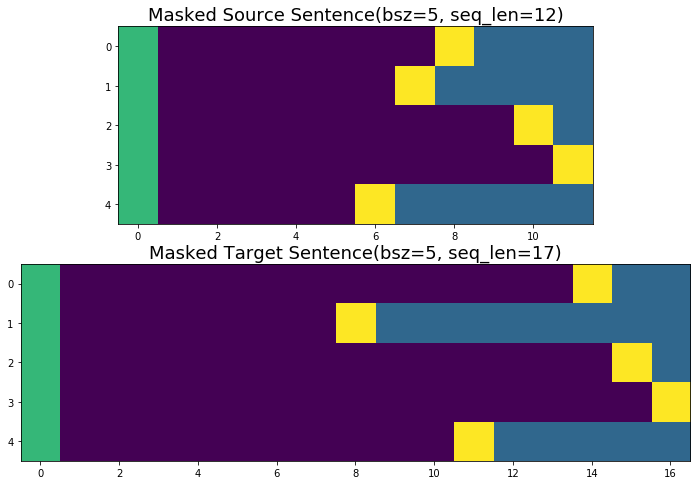

In [22]:
fig = plt.figure(figsize=(12, 8), facecolor='w')
ax1 = fig.add_subplot(2,1,1)
ax2 = fig.add_subplot(2,1,2)
ax1.imshow(x_.detach().numpy())
ax2.imshow(y_.detach().numpy())
ax1.set_title(f'Masked Source Sentence(bsz=5, seq_len={x_.size(1)})', fontsize=18)
ax2.set_title(f'Masked Target Sentence(bsz=5, seq_len={y_.size(1)})', fontsize=18)
plt.show()

Set HyperParameter of Transformer

In [23]:
INPUT_SIZE   = len(SRC_VOCAB_DICT)
OUTPUT_SIZE  = len(TRG_VOCAB_DICT)
HIDDEN_SIZE  = 256
N_SPLITS     = 8
N_ENC_BLOCKS = 6
N_DEC_BLOCKS = 6
DROPOUT_P    = 0.2

Start Transformer's Forward!

In [24]:
x

tensor([[    2, 10549,  3900, 45910,  3680, 45908,  2282,    16,     3,     1,
             1,     1],
        [    2,  2977,  5923,   956, 88842,    39,  2539,     3,     1,     1,
             1,     1],
        [    2,  1230,  1231,  1232,  1233,   323,  1234,  1235,  1236,   110,
             3,     1],
        [    2,  6726, 22523,  2457,   804, 61496,   105, 78511,  1664, 11442,
         71906,     3],
        [    2,  3085,   394,  2615,   133, 26667,     3,     1,     1,     1,
             1,     1]])

In [25]:
# make mask
mask = []
length = (x != 1).sum(dim=-1).tolist()
max_length = max(length)
for l in length:
    if max_length - l > 0:
        mask += [torch.cat([x.new_ones(1, l).zero_(),
                            x.new_ones(1, (max_length-l))
                           ], dim=-1)]
    else:
        mask += [x.new_ones(1, l).zero_()]
mask = torch.cat(mask, dim=0).bool()
mask # |mask| = (batch_size, n)

tensor([[False, False, False, False, False, False, False, False, False,  True,
          True,  True],
        [False, False, False, False, False, False, False, False,  True,  True,
          True,  True],
        [False, False, False, False, False, False, False, False, False, False,
         False,  True],
        [False, False, False, False, False, False, False, False, False, False,
         False, False],
        [False, False, False, False, False, False, False,  True,  True,  True,
          True,  True]])

In [26]:
x == SRC_VOCAB_DICT[PAD_TOKEN] # it is same to mask

tensor([[False, False, False, False, False, False, False, False, False,  True,
          True,  True],
        [False, False, False, False, False, False, False, False,  True,  True,
          True,  True],
        [False, False, False, False, False, False, False, False, False, False,
         False,  True],
        [False, False, False, False, False, False, False, False, False, False,
         False, False],
        [False, False, False, False, False, False, False,  True,  True,  True,
          True,  True]])

In [27]:
mask_enc = mask.unsqueeze(1).expand(mask.size(0), x.size(1), mask.size(-1))
mask_dec = mask.unsqueeze(1).expand(mask.size(0), y.size(1), mask.size(-1))

print(f"|mask_enc|={mask_enc.shape}=(batch_size, n, n)\n"
      f"|mask_dec|={mask_dec.shape}=(batch_size, m, n)")

|mask_enc|=torch.Size([5, 12, 12])=(batch_size, n, n)
|mask_dec|=torch.Size([5, 17, 12])=(batch_size, m, n)


$\text{EmbEncLayer}=\mathbb{N}_{[0,input\_size-1]} \rightarrow \mathbb{R}^{hidden\_size}$

In [28]:
# discrete token -> continuous token
# \mathbb{N}_{[0,input_size-1]} -> \mathbb{R}^{hidden_size}
emb_enc = nn.Embedding(INPUT_SIZE, HIDDEN_SIZE)
emb_enc.weight.size()

torch.Size([117303, 256])

In [29]:
embedded_x = emb_enc(x)
print(f"|emb_enc(x)|={embedded_x.shape}=(batch_size,n,hidden_size)")

|emb_enc(x)|=torch.Size([5, 12, 256])=(batch_size,n,hidden_size)


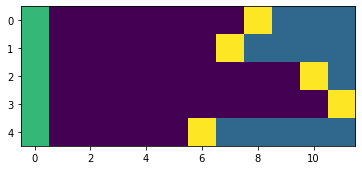

In [93]:
plt.imshow(x_.detach().numpy())

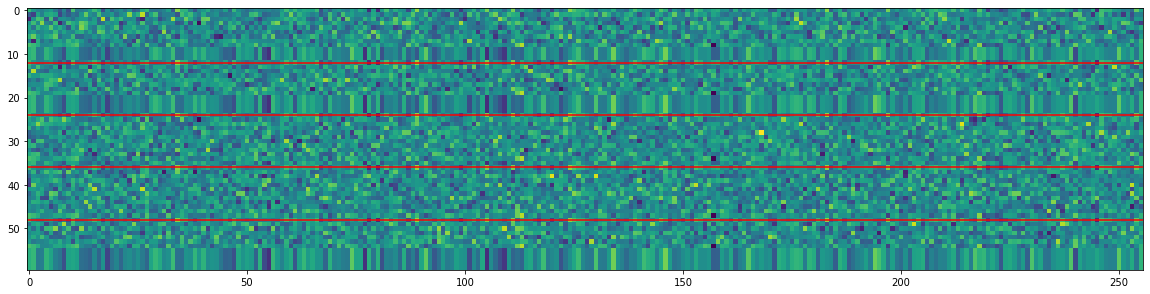

In [38]:
plt.figure(figsize=(20, 16))
plt.imshow(
    (embedded_x.view(-1, HIDDEN_SIZE)).detach().numpy()
)
for i in range(1, 5):
    plt.axhline(12*i, color='r')

In [39]:
# _position_encoding
length, hidden_size = embedded_x.size()[1:]
print(f"length: {length} | hidden_size: {hidden_size}")
enc = embedded_x.new_zeros(embedded_x.shape[1:])
enc2 = embedded_x.new_zeros(embedded_x.shape[1:])
print(f"|enc|={enc.shape}=(n,hidden_size)")
init_pos = 0 # argument, default is 0
pos = init_pos + torch.arange(0, length).float().unsqueeze(-1)
dim = (10000. ** (torch.arange(0, hidden_size//2).div(hidden_size))).unsqueeze(0)
dim2 = (10000. ** (torch.arange(0, hidden_size).float().div(hidden_size))).unsqueeze(0)
dim2 = dim2[:, 0::2] # 짝수부분만 추출
enc[:, 0::2] = torch.sin(pos/dim)
enc[:, 1::2] = torch.cos(pos/dim)
enc2[:, 0::2] = torch.sin(pos/dim2)
enc2[:, 1::2] = torch.cos(pos/dim2)

length: 12 | hidden_size: 256
|enc|=torch.Size([12, 256])=(n,hidden_size)


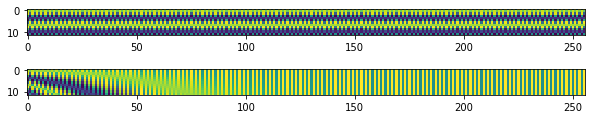

In [40]:
fig = plt.figure(figsize=(10, 2), facecolor='w')
ax1 = fig.add_subplot(2,1,1)
ax2 = fig.add_subplot(2,1,2)
ax1.imshow(enc.detach().numpy())
ax2.imshow(enc2.detach().numpy())
plt.show()

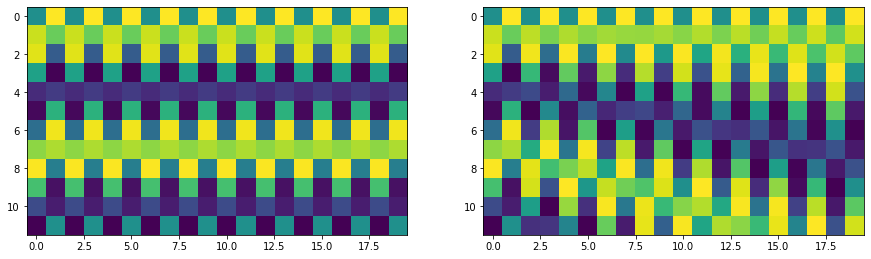

In [41]:
fig = plt.figure(figsize=(15, 20), facecolor='w')
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
ax1.imshow(enc[:, :20].detach().numpy())
ax2.imshow(enc2[:, :20].detach().numpy())
plt.show()

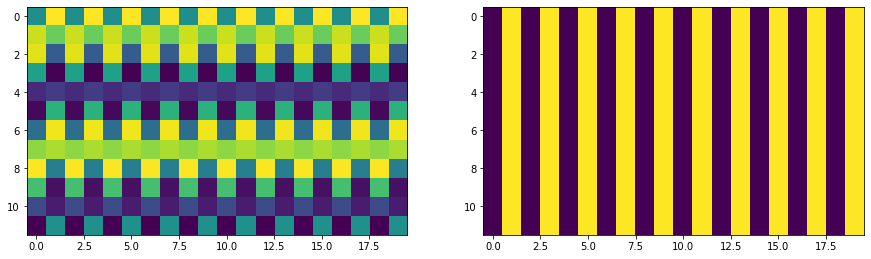

In [42]:
fig = plt.figure(figsize=(15, 20), facecolor='w')
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
ax1.imshow(enc[:, -20:].detach().numpy())
ax2.imshow(enc2[:, -20:].detach().numpy())
plt.show()

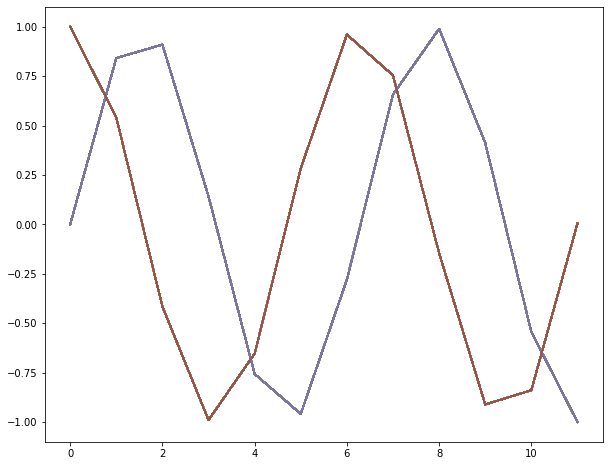

In [43]:
plt.figure(figsize=(10, 8), facecolor='w')
for i in range(hidden_size):
    plt.plot(enc[:, i].detach().numpy())

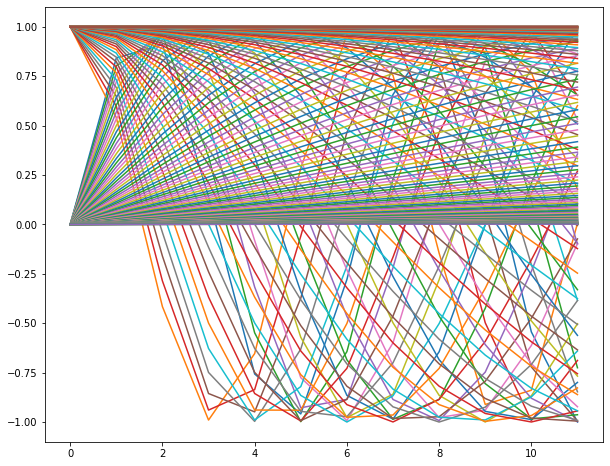

In [44]:
plt.figure(figsize=(10, 8), facecolor='w')
for i in range(hidden_size):
    plt.plot(enc2[:, i].detach().numpy())

In [45]:
embedded_x += enc

In [46]:
emb_dropout = nn.Dropout(DROPOUT_P)

In [47]:
z = emb_dropout(embedded_x)

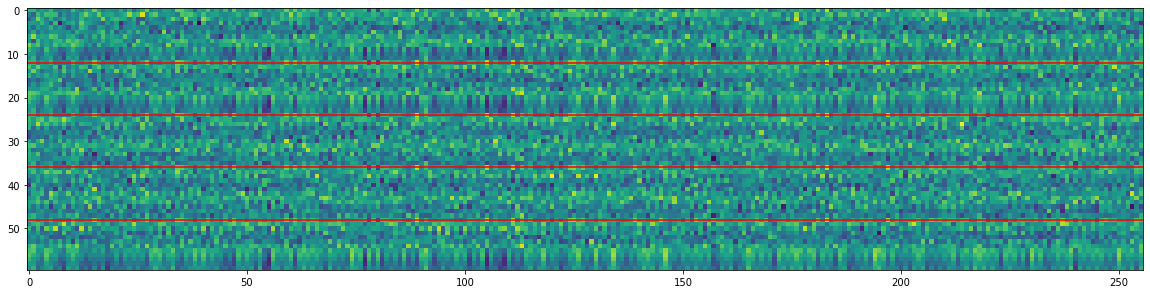

In [48]:
plt.figure(figsize=(20, 16))
plt.imshow(
    (embedded_x.view(-1, HIDDEN_SIZE)).detach().numpy()
)
for i in range(1, 5):
    plt.axhline(12*i, color='r')

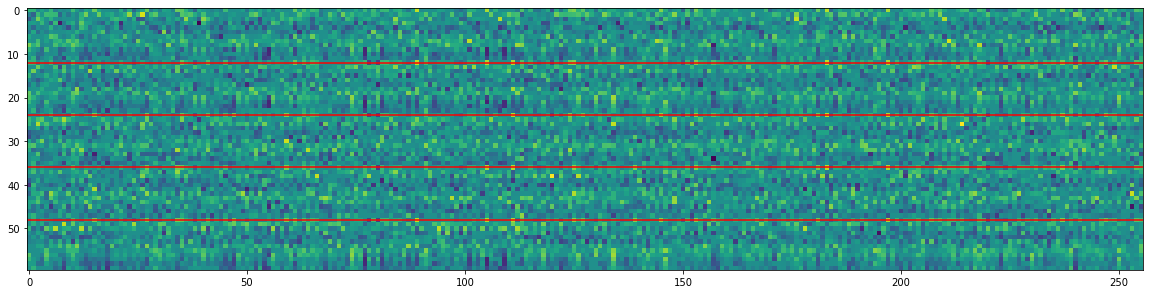

In [49]:
plt.figure(figsize=(20, 16))
plt.imshow(
    (z.view(-1, HIDDEN_SIZE)).detach().numpy()
)
for i in range(1, 5):
    plt.axhline(12*i, color='r')

---

- Dropout Layer를 잠시 살펴보자!

Standard neural network

$$z_i^{(l+1)}=w_i^{(l+1)}y^{(l)}+b_i^{(l+1)}$$
$$y_i^{(l+1)}=f\big({z_i^{(l+1)}}\big)$$


Dropout neural network

$$r_j^{(l)}\sim Bernoulli(p)$$
$$\tilde{y}^{(l)}=r^{(l)}*y^{(l)}$$
$$z_i^{(l+1)}=w_i^{(l+1)}\tilde{y}^{(l)}+b_i^{(l+1)}$$
$$y_i^{(l+1)}=f\big({z_i^{(l+1)}}\big)$$

In [39]:
ex = torch.randn((3,5))
ex

tensor([[-0.0972, -1.1203,  0.1504, -0.7347,  0.2880],
        [ 1.5785, -0.9836,  0.2161, -2.0865, -1.1041],
        [ 0.7129,  1.1994,  2.2042, -0.9272,  0.5719]])

In [40]:
z_ = nn.Dropout(0.3)(ex)
z_

tensor([[-0.1388, -1.6004,  0.2148, -0.0000,  0.4114],
        [ 2.2550, -1.4051,  0.3088, -2.9807, -1.5773],
        [ 1.0184,  1.7134,  3.1488, -1.3245,  0.0000]])

In [41]:
z_[z_ != 0] / ex[z_ != 0]

tensor([1.4286, 1.4286, 1.4286, 1.4286, 1.4286, 1.4286, 1.4286, 1.4286, 1.4286,
        1.4286, 1.4286, 1.4286, 1.4286])

In [42]:
res = []
for i in range(10000):
    res.append(
        ((emb_dropout(torch.randn((3, 5))) == 0).sum().float() / 15).item()
    )

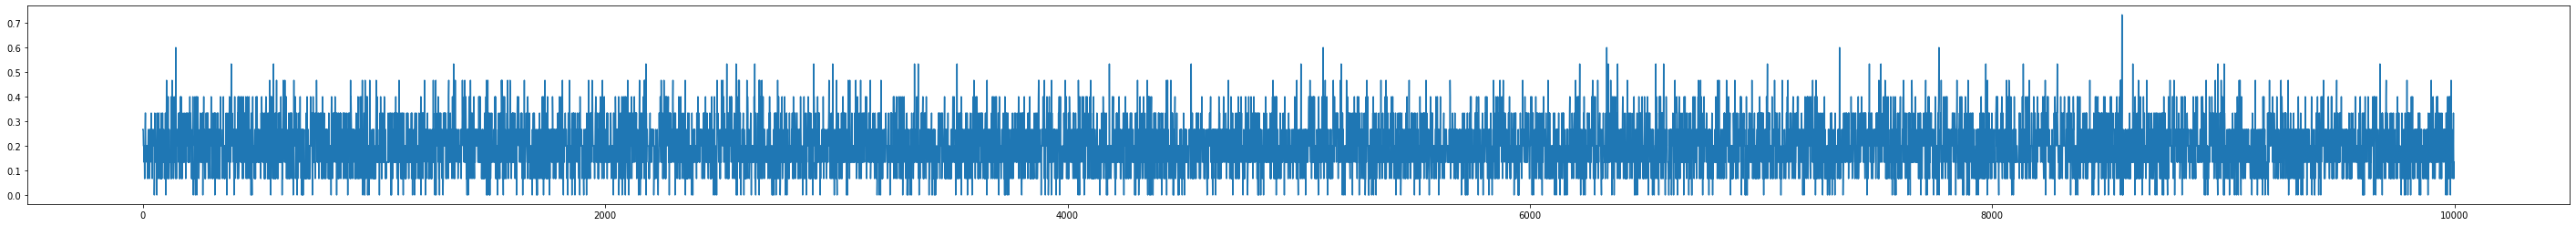

In [43]:
plt.figure(figsize=(50, 4), facecolor='w')
plt.plot(res)

In [44]:
np.mean(res)

0.19902000680714846

---

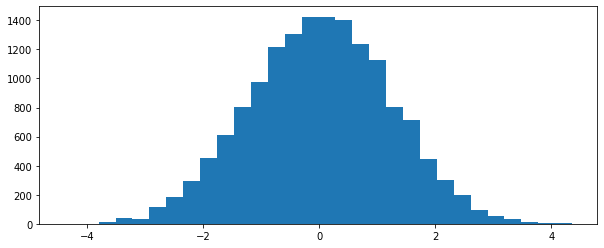

In [50]:
plt.figure(figsize=(10, 4), facecolor='w')
plt.hist(
    (embedded_x.view(-1, hidden_size)).flatten().detach().numpy(),
    bins=30
); plt.show()

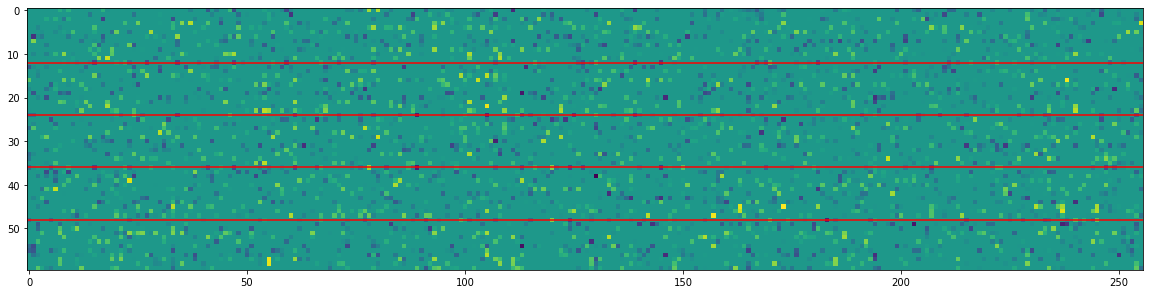

In [51]:
plt.figure(figsize=(20, 16))
plt.imshow(
    (z.view(-1, hidden_size) * (1 - DROPOUT_P) - embedded_x.view(-1, hidden_size)).detach().numpy()
)
for i in range(1, 5):
    plt.axhline(12*i, color='r')

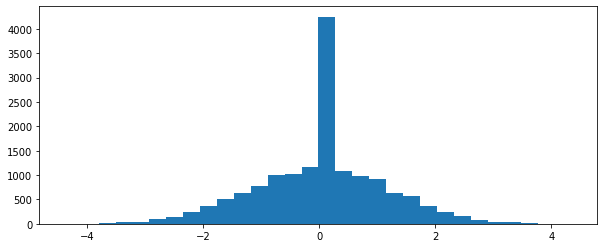

In [52]:
plt.figure(figsize=(10, 4), facecolor='w')
plt.hist(
    (z.view(-1, hidden_size) * (1 - DROPOUT_P)).flatten().detach().numpy(),
    bins=30
); plt.show()

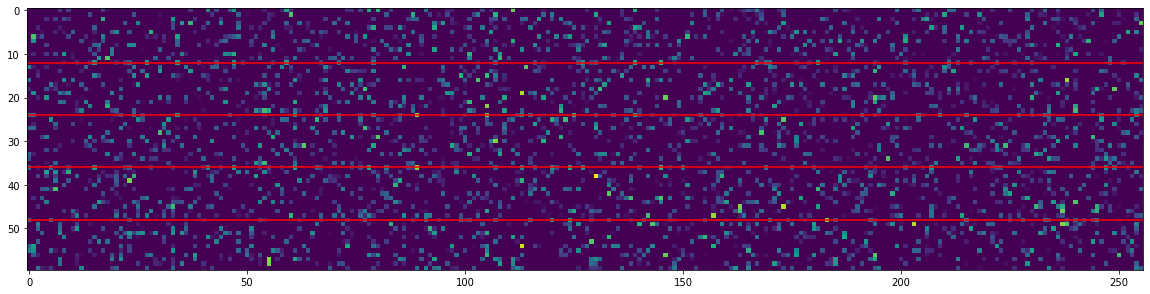

In [53]:
plt.figure(figsize=(20, 16))
plt.imshow(
    (torch.abs(embedded_x.view(-1, hidden_size) * (1 / (1 - DROPOUT_P)) - z.view(-1, hidden_size))).detach().numpy()
)
for i in range(1, 5):
    plt.axhline(12*i, color='r')

In [51]:
# z = emb_dropout(embedded_x)

In [57]:
1 - ((embedded_x - z * (1 - DROPOUT_P)) < 1e-10).sum().float() / (5 * 12 * 256)

tensor(0.1992)

In [59]:
print(z, z.shape)

tensor([[[ 1.6725,  1.6474, -0.3755,  ..., -0.0325,  2.4488,  2.0354],
         [-0.6413, -1.9916,  1.9148,  ..., -1.5678,  0.0000,  0.2123],
         [-2.3519, -0.3171,  3.1370,  ..., -2.3119,  0.0000, -0.2085],
         ...,
         [ 1.8122,  0.4779, -0.2154,  ..., -0.0000, -0.3977,  0.0000],
         [ 0.6170,  0.0000, -1.4106,  ...,  0.0533, -1.5929,  0.4781],
         [ 0.0471,  1.6224, -1.9806,  ...,  1.1077, -2.1628,  1.5325]],

        [[ 1.6725,  1.6474, -0.3755,  ..., -0.0325,  2.4488,  2.0354],
         [ 0.0000,  0.0000,  2.9753,  ..., -0.9224, -1.1557,  1.8556],
         [ 0.3699,  3.1214,  0.0000,  ..., -0.1317,  0.6946, -1.5034],
         ...,
         [ 1.8122,  0.4779, -0.2154,  ..., -0.0367, -0.3977,  0.3880],
         [ 0.6170,  0.5680, -1.4106,  ...,  0.0533, -1.5929,  0.0000],
         [ 0.0000,  1.6224, -1.9806,  ...,  0.0000, -0.0000,  0.0000]],

        [[ 0.0000,  0.0000, -0.3755,  ..., -0.0325,  0.0000,  2.0354],
         [ 1.9193,  0.6656,  2.2223,  ...,  0

In [60]:
# Encoder Block 1

## MultiHead-Attention
Q_linear_1 = nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE, bias=False)
K_linear_1 = nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE, bias=False)
V_linear_1 = nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE, bias=False)
linear_1   = nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE, bias=False)

Q = K = V = z
mask = mask_enc

QWs = Q_linear_1(Q).split(HIDDEN_SIZE // N_SPLITS, dim=-1)
KWs = K_linear_1(K).split(HIDDEN_SIZE // N_SPLITS, dim=-1)
VWs = V_linear_1(V).split(HIDDEN_SIZE // N_SPLITS, dim=-1)

QWs = torch.cat(QWs, dim=0)
KWs = torch.cat(KWs, dim=0)
VWs = torch.cat(VWs, dim=0)

mask = torch.cat([mask for _ in range(N_SPLITS)], dim=0)

# Self-Attention
dk = HIDDEN_SIZE // N_SPLITS
softmax = nn.Softmax(dim=-1)
w = torch.bmm(QWs, KWs.transpose(1, 2))
w.masked_fill_(mask, -float('inf'))
w = softmax(w / (dk ** .5))
c = torch.bmm(w, VWs)

c = c.split(Q.size(0), dim=0)
c = linear_1(torch.cat(c, dim=-1))

## Sub-Layer
## LayerNorm(x + Dropout(MultiHeadAttn(x)))
## where MultiHeadAttn(x) == c
attn_norm_1 = nn.LayerNorm(HIDDEN_SIZE)
attn_dropout_1 = nn.Dropout(DROPOUT_P)
### position-wise feed-forward networks
### Attentnion의 결과를 정리해주는 역할을 수행(한다고함)
fc_1 = nn.Sequential(
    nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE * 4),
    nn.ReLU(),
    nn.Linear(HIDDEN_SIZE * 4, HIDDEN_SIZE),
)
fc_norm_1 = nn.LayerNorm(HIDDEN_SIZE)
fc_dropout_1 = nn.Dropout(DROPOUT_P)

z = attn_norm_1(z + attn_dropout_1(c))
z = fc_norm_1(z + fc_dropout_1(fc_1(z)))

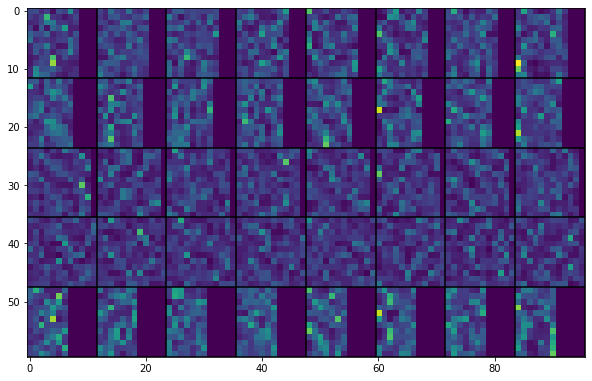

In [61]:
plt.figure(figsize=(10, 8), facecolor='w')
plt.imshow(
    torch.cat(w.split(5), dim=-1).view(5*12, -1).detach().numpy()
)
for i in range(8):
    plt.axvline(12*(i+1)-0.5, color='k')
for i in range(5):
    plt.axhline(12*(i+1)-0.5, color='k')

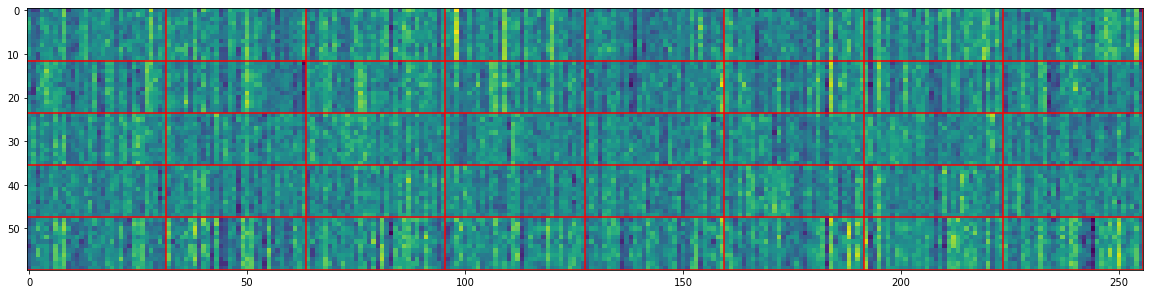

In [62]:
plt.figure(figsize=(20, 16), facecolor='w')
plt.imshow(
    c.view(5*12, -1).detach().numpy()
)
for i in range(8):
    plt.axvline(32*(i+1)-0.5, color='r')
for i in range(5):
    plt.axhline(12*(i+1)-0.5, color='r')

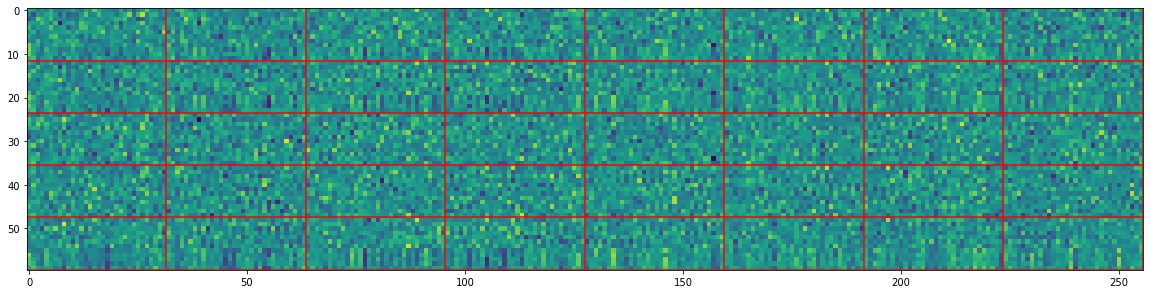

In [63]:
plt.figure(figsize=(20, 16), facecolor='w')
plt.imshow(
    z.view(5*12, -1).detach().numpy()
)
for i in range(8):
    plt.axvline(32*(i+1)-0.5, color='r')
for i in range(5):
    plt.axhline(12*(i+1)-0.5, color='r')

In [64]:
# Encoder Block 2

## MultiHead-Attention
Q_linear_2 = nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE, bias=False)
K_linear_2 = nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE, bias=False)
V_linear_2 = nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE, bias=False)
linear_2   = nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE, bias=False)

Q = K = V = z
mask = mask

QWs = Q_linear_2(Q).split(HIDDEN_SIZE // N_SPLITS, dim=-1)
KWs = K_linear_2(K).split(HIDDEN_SIZE // N_SPLITS, dim=-1)
VWs = V_linear_2(V).split(HIDDEN_SIZE // N_SPLITS, dim=-1)

QWs = torch.cat(QWs, dim=0)
KWs = torch.cat(KWs, dim=0)
VWs = torch.cat(VWs, dim=0)

# mask = torch.cat([mask for _ in range(N_SPLITS)], dim=0)

# Self-Attention
dk = HIDDEN_SIZE // N_SPLITS
softmax = nn.Softmax(dim=-1)
w = torch.bmm(QWs, KWs.transpose(1, 2))
w.masked_fill_(mask, -float('inf'))
w = softmax(w / (dk ** .5))
c = torch.bmm(w, VWs)

c = c.split(Q.size(0), dim=0)
c = linear_2(torch.cat(c, dim=-1))

## Sub-Layer
## LayerNorm(x + Dropout(MultiHeadAttn(x)))
## where MultiHeadAttn(x) == c
attn_norm_2 = nn.LayerNorm(HIDDEN_SIZE)
attn_dropout_2 = nn.Dropout(DROPOUT_P)
### position-wise feed-forward networks
### Attentnion의 결과를 정리해주는 역할을 수행(한다고함)
fc_2 = nn.Sequential(
    nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE * 4),
    nn.ReLU(),
    nn.Linear(HIDDEN_SIZE * 4, HIDDEN_SIZE),
)
fc_norm_2 = nn.LayerNorm(HIDDEN_SIZE)
fc_dropout_2 = nn.Dropout(DROPOUT_P)

z = attn_norm_2(z + attn_dropout_2(c))
z = fc_norm_2(z + fc_dropout_2(fc_2(z)))

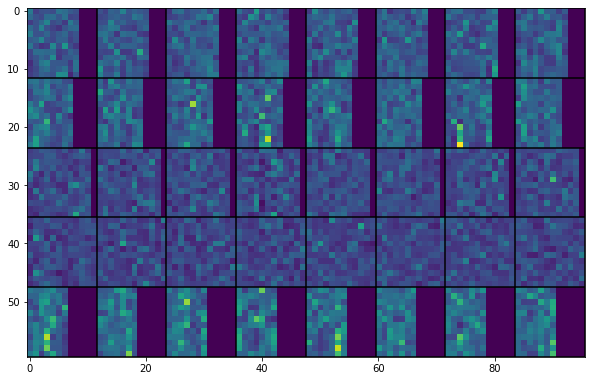

In [65]:
plt.figure(figsize=(10, 8), facecolor='w')
plt.imshow(
    torch.cat(w.split(5), dim=-1).view(5*12, -1).detach().numpy()
)
for i in range(8):
    plt.axvline(12*(i+1)-0.5, color='k')
for i in range(5):
    plt.axhline(12*(i+1)-0.5, color='k')

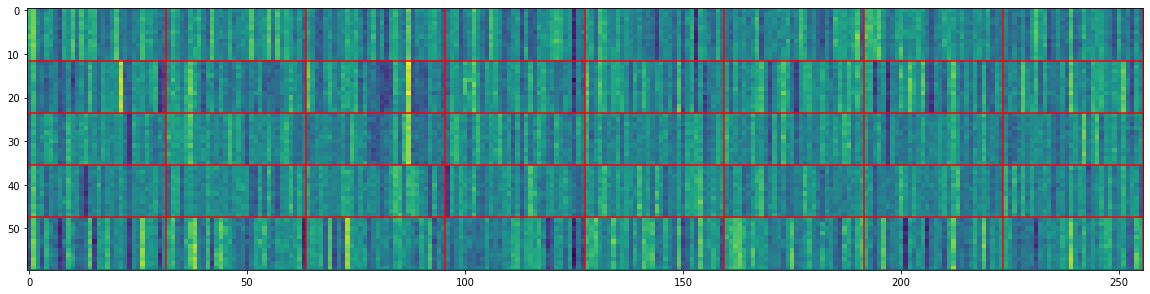

In [66]:
plt.figure(figsize=(20, 16), facecolor='w')
plt.imshow(
    c.view(5*12, -1).detach().numpy()
)
for i in range(8):
    plt.axvline(32*(i+1)-0.5, color='r')
for i in range(5):
    plt.axhline(12*(i+1)-0.5, color='r')

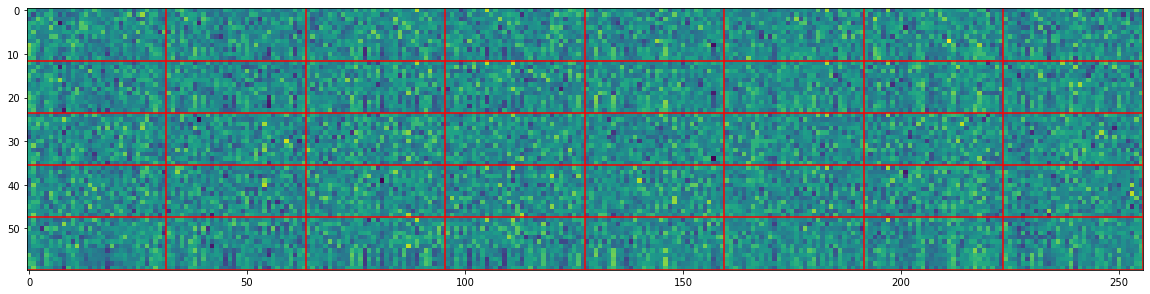

In [67]:
plt.figure(figsize=(20, 16), facecolor='w')
plt.imshow(
    z.view(5*12, -1).detach().numpy()
)
for i in range(8):
    plt.axvline(32*(i+1)-0.5, color='r')
for i in range(5):
    plt.axhline(12*(i+1)-0.5, color='r')

In [68]:
# Encoder Block 3

## MultiHead-Attention
Q_linear_3 = nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE, bias=False)
K_linear_3 = nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE, bias=False)
V_linear_3 = nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE, bias=False)
linear_3   = nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE, bias=False)

Q = K = V = z
mask = mask

QWs = Q_linear_3(Q).split(HIDDEN_SIZE // N_SPLITS, dim=-1)
KWs = K_linear_3(K).split(HIDDEN_SIZE // N_SPLITS, dim=-1)
VWs = V_linear_3(V).split(HIDDEN_SIZE // N_SPLITS, dim=-1)

QWs = torch.cat(QWs, dim=0)
KWs = torch.cat(KWs, dim=0)
VWs = torch.cat(VWs, dim=0)

# mask = torch.cat([mask for _ in range(N_SPLITS)], dim=0)

# Self-Attention
dk = HIDDEN_SIZE // N_SPLITS
softmax = nn.Softmax(dim=-1)
w = torch.bmm(QWs, KWs.transpose(1, 2))
w.masked_fill_(mask, -float('inf'))
w = softmax(w / (dk ** .5))
c = torch.bmm(w, VWs)

c = c.split(Q.size(0), dim=0)
c = linear_3(torch.cat(c, dim=-1))

## Sub-Layer
## LayerNorm(x + Dropout(MultiHeadAttn(x)))
## where MultiHeadAttn(x) == c
attn_norm_3 = nn.LayerNorm(HIDDEN_SIZE)
attn_dropout_3 = nn.Dropout(DROPOUT_P)
### position-wise feed-forward networks
### Attentnion의 결과를 정리해주는 역할을 수행(한다고함)
fc_3 = nn.Sequential(
    nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE * 4),
    nn.ReLU(),
    nn.Linear(HIDDEN_SIZE * 4, HIDDEN_SIZE),
)
fc_norm_3 = nn.LayerNorm(HIDDEN_SIZE)
fc_dropout_3 = nn.Dropout(DROPOUT_P)

z = attn_norm_3(z + attn_dropout_3(c))
z = fc_norm_3(z + fc_dropout_3(fc_3(z)))

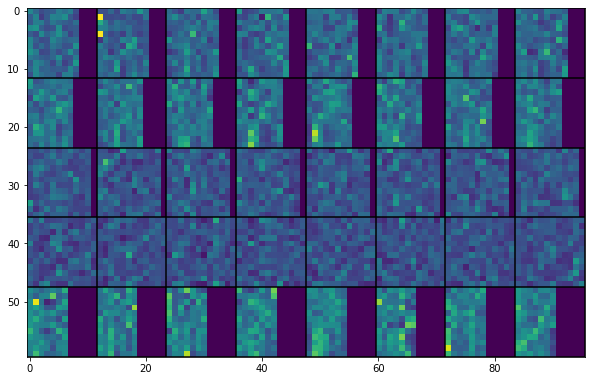

In [69]:
plt.figure(figsize=(10, 8), facecolor='w')
plt.imshow(
    torch.cat(w.split(5), dim=-1).view(5*12, -1).detach().numpy()
)
for i in range(8):
    plt.axvline(12*(i+1)-0.5, color='k')
for i in range(5):
    plt.axhline(12*(i+1)-0.5, color='k')

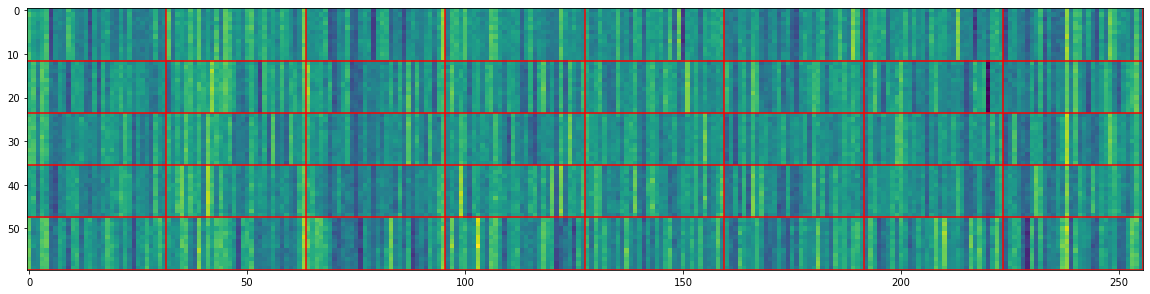

In [70]:
plt.figure(figsize=(20, 16), facecolor='w')
plt.imshow(
    c.view(5*12, -1).detach().numpy()
)
for i in range(8):
    plt.axvline(32*(i+1)-0.5, color='r')
for i in range(5):
    plt.axhline(12*(i+1)-0.5, color='r')

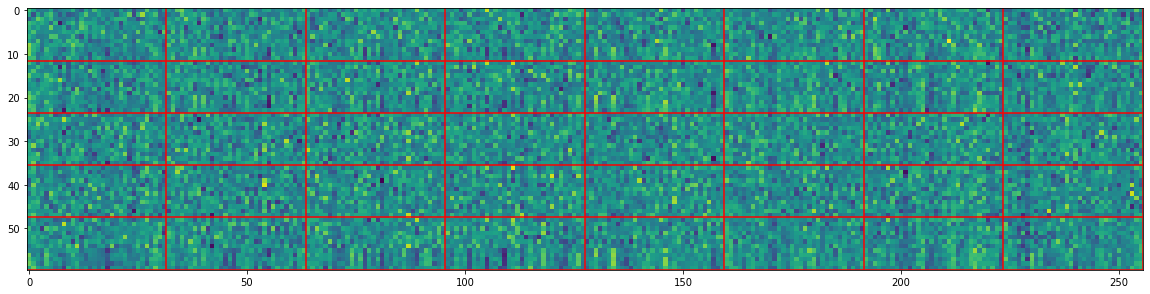

In [71]:
plt.figure(figsize=(20, 16), facecolor='w')
plt.imshow(
    z.view(5*12, -1).detach().numpy()
)
for i in range(8):
    plt.axvline(32*(i+1)-0.5, color='r')
for i in range(5):
    plt.axhline(12*(i+1)-0.5, color='r')

In [72]:
# Encoder Block 4

## MultiHead-Attention
Q_linear_4 = nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE, bias=False)
K_linear_4 = nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE, bias=False)
V_linear_4 = nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE, bias=False)
linear_4   = nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE, bias=False)

Q = K = V = z
mask = mask

QWs = Q_linear_4(Q).split(HIDDEN_SIZE // N_SPLITS, dim=-1)
KWs = K_linear_4(K).split(HIDDEN_SIZE // N_SPLITS, dim=-1)
VWs = V_linear_4(V).split(HIDDEN_SIZE // N_SPLITS, dim=-1)

QWs = torch.cat(QWs, dim=0)
KWs = torch.cat(KWs, dim=0)
VWs = torch.cat(VWs, dim=0)

# mask = torch.cat([mask for _ in range(N_SPLITS)], dim=0)

# Self-Attention
dk = HIDDEN_SIZE // N_SPLITS
softmax = nn.Softmax(dim=-1)
w = torch.bmm(QWs, KWs.transpose(1, 2))
w.masked_fill_(mask, -float('inf'))
w = softmax(w / (dk ** .5))
c = torch.bmm(w, VWs)

c = c.split(Q.size(0), dim=0)
c = linear_4(torch.cat(c, dim=-1))

## Sub-Layer
## LayerNorm(x + Dropout(MultiHeadAttn(x)))
## where MultiHeadAttn(x) == c
attn_norm_4 = nn.LayerNorm(HIDDEN_SIZE)
attn_dropout_4 = nn.Dropout(DROPOUT_P)
### position-wise feed-forward networks
### Attentnion의 결과를 정리해주는 역할을 수행(한다고함)
fc_4 = nn.Sequential(
    nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE * 4),
    nn.ReLU(),
    nn.Linear(HIDDEN_SIZE * 4, HIDDEN_SIZE),
)
fc_norm_4 = nn.LayerNorm(HIDDEN_SIZE)
fc_dropout_4 = nn.Dropout(DROPOUT_P)

z = attn_norm_4(z + attn_dropout_4(c))
z = fc_norm_4(z + fc_dropout_4(fc_4(z)))

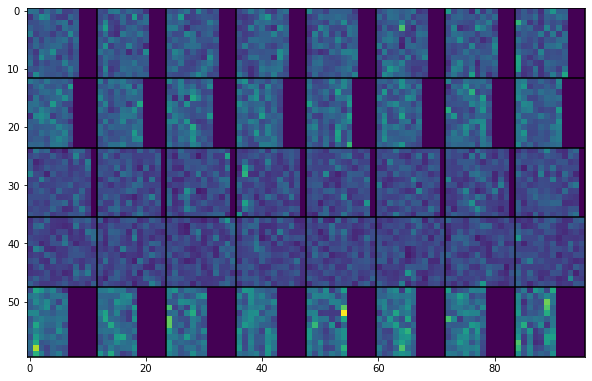

In [73]:
plt.figure(figsize=(10, 8), facecolor='w')
plt.imshow(
    torch.cat(w.split(5), dim=-1).view(5*12, -1).detach().numpy()
)
for i in range(8):
    plt.axvline(12*(i+1)-0.5, color='k')
for i in range(5):
    plt.axhline(12*(i+1)-0.5, color='k')

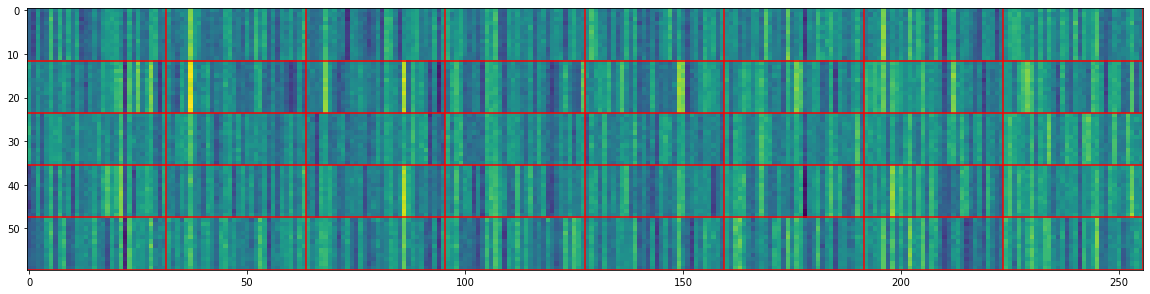

In [74]:
plt.figure(figsize=(20, 16), facecolor='w')
plt.imshow(
    c.view(5*12, -1).detach().numpy()
)
for i in range(8):
    plt.axvline(32*(i+1)-0.5, color='r')
for i in range(5):
    plt.axhline(12*(i+1)-0.5, color='r')

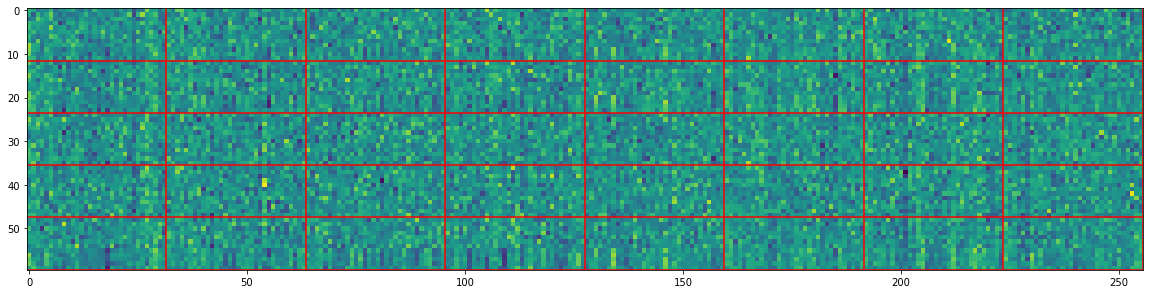

In [75]:
plt.figure(figsize=(20, 16), facecolor='w')
plt.imshow(
    z.view(5*12, -1).detach().numpy()
)
for i in range(8):
    plt.axvline(32*(i+1)-0.5, color='r')
for i in range(5):
    plt.axhline(12*(i+1)-0.5, color='r')

In [76]:
# Encoder Block 5

## MultiHead-Attention
Q_linear_5 = nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE, bias=False)
K_linear_5 = nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE, bias=False)
V_linear_5 = nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE, bias=False)
linear_5   = nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE, bias=False)

Q = K = V = z
mask = mask

QWs = Q_linear_5(Q).split(HIDDEN_SIZE // N_SPLITS, dim=-1)
KWs = K_linear_5(K).split(HIDDEN_SIZE // N_SPLITS, dim=-1)
VWs = V_linear_5(V).split(HIDDEN_SIZE // N_SPLITS, dim=-1)

QWs = torch.cat(QWs, dim=0)
KWs = torch.cat(KWs, dim=0)
VWs = torch.cat(VWs, dim=0)

# mask = torch.cat([mask for _ in range(N_SPLITS)], dim=0)

# Self-Attention
dk = HIDDEN_SIZE // N_SPLITS
softmax = nn.Softmax(dim=-1)
w = torch.bmm(QWs, KWs.transpose(1, 2))
w.masked_fill_(mask, -float('inf'))
w = softmax(w / (dk ** .5))
c = torch.bmm(w, VWs)

c = c.split(Q.size(0), dim=0)
c = linear_5(torch.cat(c, dim=-1))

## Sub-Layer
## LayerNorm(x + Dropout(MultiHeadAttn(x)))
## where MultiHeadAttn(x) == c
attn_norm_5 = nn.LayerNorm(HIDDEN_SIZE)
attn_dropout_5 = nn.Dropout(DROPOUT_P)
### position-wise feed-forward networks
### Attentnion의 결과를 정리해주는 역할을 수행(한다고함)
fc_5 = nn.Sequential(
    nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE * 4),
    nn.ReLU(),
    nn.Linear(HIDDEN_SIZE * 4, HIDDEN_SIZE),
)
fc_norm_5 = nn.LayerNorm(HIDDEN_SIZE)
fc_dropout_5 = nn.Dropout(DROPOUT_P)

z = attn_norm_5(z + attn_dropout_5(c))
z = fc_norm_5(z + fc_dropout_5(fc_5(z)))

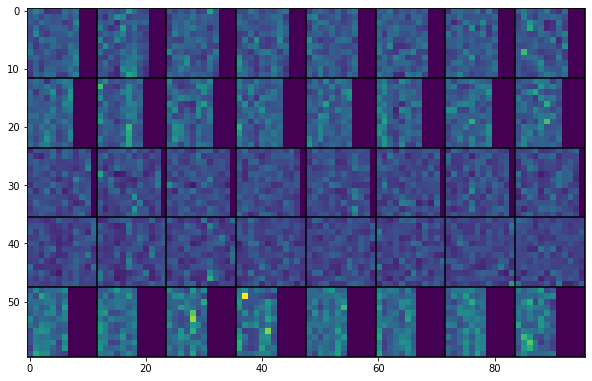

In [77]:
plt.figure(figsize=(10, 8), facecolor='w')
plt.imshow(
    torch.cat(w.split(5), dim=-1).view(5*12, -1).detach().numpy()
)
for i in range(8):
    plt.axvline(12*(i+1)-0.5, color='k')
for i in range(5):
    plt.axhline(12*(i+1)-0.5, color='k')

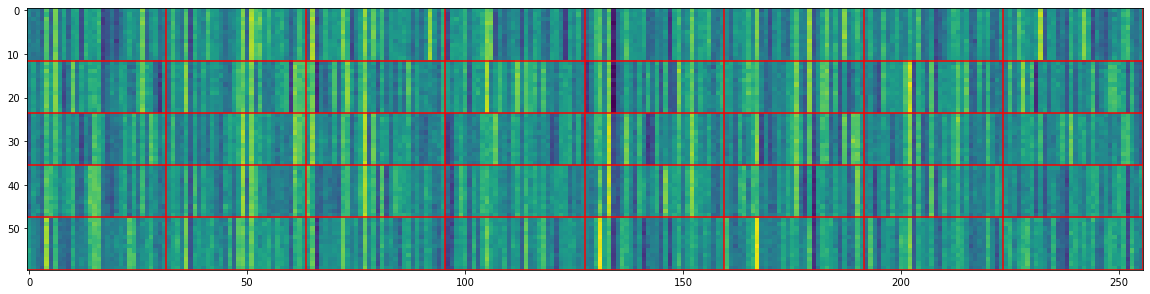

In [78]:
plt.figure(figsize=(20, 16), facecolor='w')
plt.imshow(
    c.view(5*12, -1).detach().numpy()
)
for i in range(8):
    plt.axvline(32*(i+1)-0.5, color='r')
for i in range(5):
    plt.axhline(12*(i+1)-0.5, color='r')

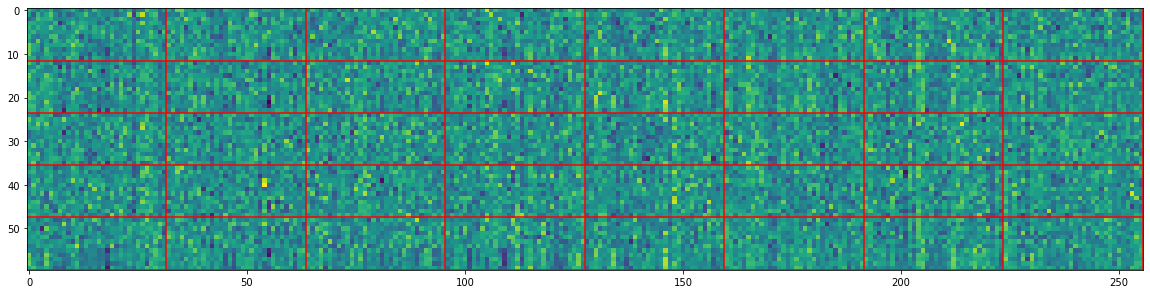

In [79]:
plt.figure(figsize=(20, 16), facecolor='w')
plt.imshow(
    z.view(5*12, -1).detach().numpy()
)
for i in range(8):
    plt.axvline(32*(i+1)-0.5, color='r')
for i in range(5):
    plt.axhline(12*(i+1)-0.5, color='r')

In [80]:
# Encoder Block 6

## MultiHead-Attention
Q_linear_6 = nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE, bias=False)
K_linear_6 = nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE, bias=False)
V_linear_6 = nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE, bias=False)
linear_6   = nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE, bias=False)

Q = K = V = z
mask = mask

QWs = Q_linear_6(Q).split(HIDDEN_SIZE // N_SPLITS, dim=-1)
KWs = K_linear_6(K).split(HIDDEN_SIZE // N_SPLITS, dim=-1)
VWs = V_linear_6(V).split(HIDDEN_SIZE // N_SPLITS, dim=-1)

QWs = torch.cat(QWs, dim=0)
KWs = torch.cat(KWs, dim=0)
VWs = torch.cat(VWs, dim=0)

# mask = torch.cat([mask for _ in range(N_SPLITS)], dim=0)

# Self-Attention
dk = HIDDEN_SIZE // N_SPLITS
softmax = nn.Softmax(dim=-1)
w = torch.bmm(QWs, KWs.transpose(1, 2))
w.masked_fill_(mask, -float('inf'))
w = softmax(w / (dk ** .5))
c = torch.bmm(w, VWs)

c = c.split(Q.size(0), dim=0)
c = linear_6(torch.cat(c, dim=-1))

## Sub-Layer
## LayerNorm(x + Dropout(MultiHeadAttn(x)))
## where MultiHeadAttn(x) == c
attn_norm_6 = nn.LayerNorm(HIDDEN_SIZE)
attn_dropout_6 = nn.Dropout(DROPOUT_P)
### position-wise feed-forward networks
### Attentnion의 결과를 정리해주는 역할을 수행(한다고함)
fc_6 = nn.Sequential(
    nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE * 4),
    nn.ReLU(),
    nn.Linear(HIDDEN_SIZE * 4, HIDDEN_SIZE),
)
fc_norm_6 = nn.LayerNorm(HIDDEN_SIZE)
fc_dropout_6 = nn.Dropout(DROPOUT_P)

z = attn_norm_6(z + attn_dropout_6(c))
z = fc_norm_6(z + fc_dropout_6(fc_6(z)))

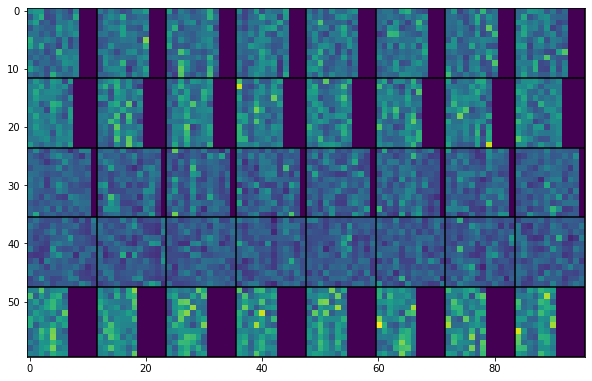

In [81]:
plt.figure(figsize=(10, 8), facecolor='w')
plt.imshow(
    torch.cat(w.split(5), dim=-1).view(5*12, -1).detach().numpy()
)
for i in range(8):
    plt.axvline(12*(i+1)-0.5, color='k')
for i in range(5):
    plt.axhline(12*(i+1)-0.5, color='k')

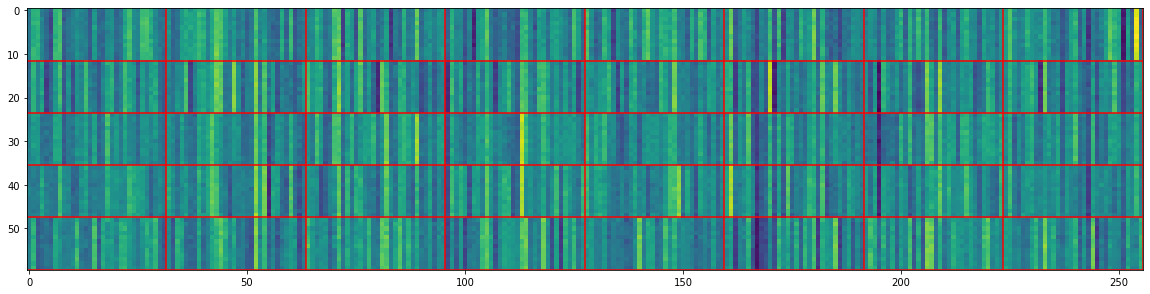

In [82]:
plt.figure(figsize=(20, 16), facecolor='w')
plt.imshow(
    c.view(5*12, -1).detach().numpy()
)
for i in range(8):
    plt.axvline(32*(i+1)-0.5, color='r')
for i in range(5):
    plt.axhline(12*(i+1)-0.5, color='r')

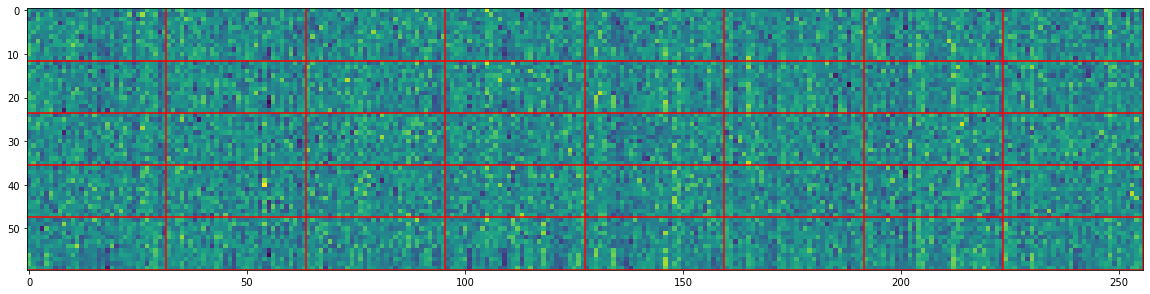

In [83]:
plt.figure(figsize=(20, 16), facecolor='w')
plt.imshow(
    z.view(5*12, -1).detach().numpy()
)
for i in range(8):
    plt.axvline(32*(i+1)-0.5, color='r')
for i in range(5):
    plt.axhline(12*(i+1)-0.5, color='r')

In [85]:
mask_dec.shape

torch.Size([5, 17, 12])

$\text{EmbDecLayer}=\mathbb{N}_{[0,output\_size-1]} \rightarrow \mathbb{R}^{hidden\_size}$

In [86]:
# discrete token -> continuous token
# \mathbb{N}_{[0,input_size-1]} -> \mathbb{R}^{hidden_size}
emb_dec = nn.Embedding(OUTPUT_SIZE, HIDDEN_SIZE)
emb_dec.weight.size()

torch.Size([34308, 256])

In [87]:
embedded_y = emb_dec(y)
print(f"|emb_dec(y)|={embedded_y.shape}=(batch_size,m,hidden_size)")

|emb_dec(y)|=torch.Size([5, 17, 256])=(batch_size,m,hidden_size)


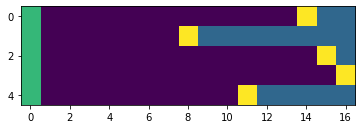

In [95]:
plt.imshow(y_.detach().numpy())

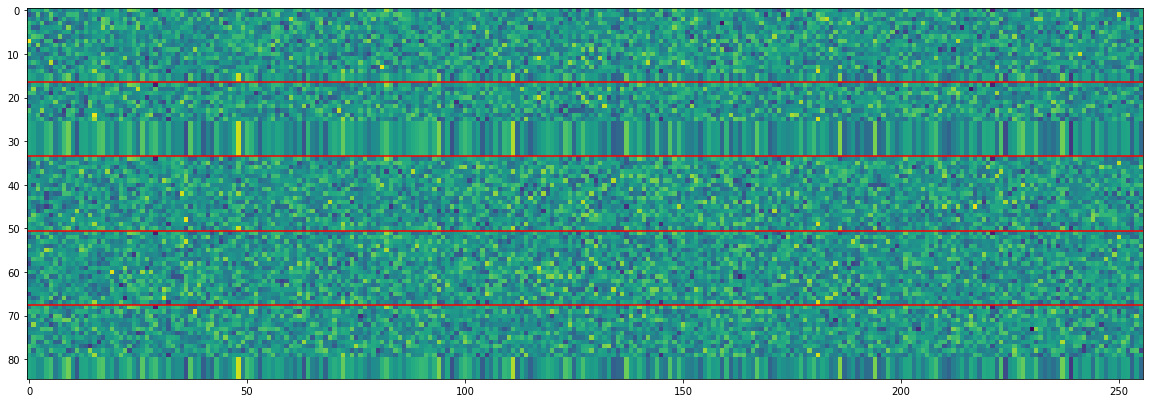

In [96]:
plt.figure(figsize=(20, 16))
plt.imshow(
    (embedded_y.view(-1, HIDDEN_SIZE)).detach().numpy()
)
for i in range(1, 5):
    plt.axhline(17*i-0.5, color='r')

In [98]:
# _position_encoding
length, hidden_size = embedded_y.size()[1:]
print(f"length: {length} | hidden_size: {hidden_size}")
dec = embedded_y.new_zeros(embedded_y.shape[1:])
print(f"|enc|={enc.shape}=(n,hidden_size)")
init_pos = 0 # argument, default is 0
pos = init_pos + torch.arange(0, length).float().unsqueeze(-1)
dim = (10000. ** (torch.arange(0, hidden_size//2).div(hidden_size))).unsqueeze(0)
dec[:, 0::2] = torch.sin(pos/dim)
dec[:, 1::2] = torch.cos(pos/dim)

length: 17 | hidden_size: 256
|enc|=torch.Size([17, 256])=(n,hidden_size)


In [99]:
embedded_y += dec

In [102]:
h = emb_dropout(embedded_y)

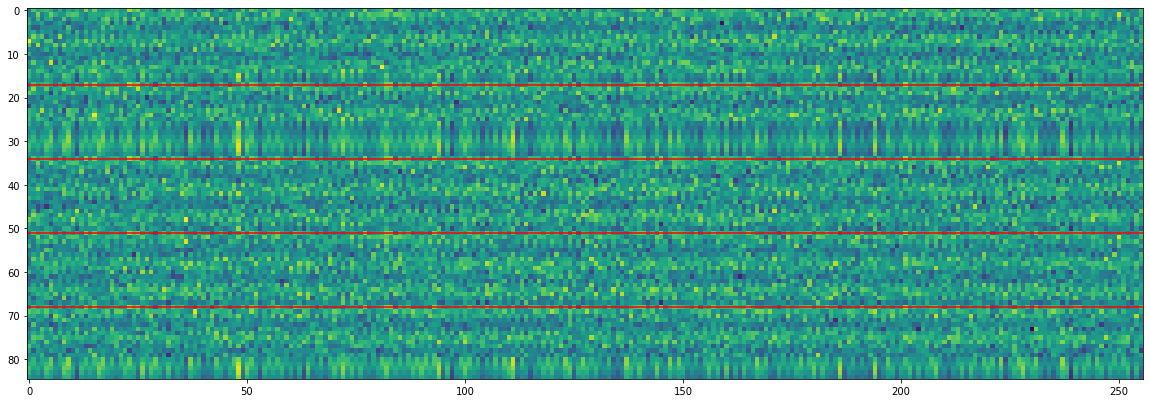

In [103]:
plt.figure(figsize=(20, 16))
plt.imshow(
    (embedded_y.view(-1, HIDDEN_SIZE)).detach().numpy()
)
for i in range(1, 5):
    plt.axhline(17*i, color='r')

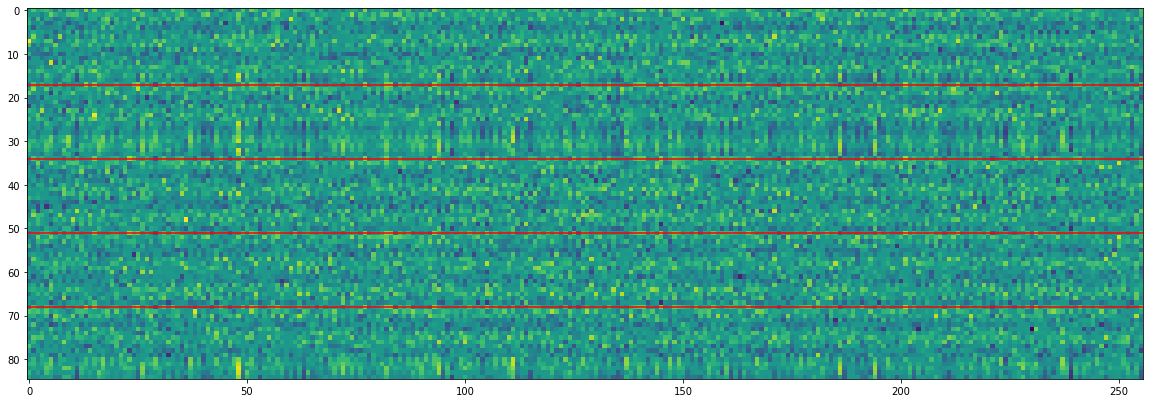

In [104]:
plt.figure(figsize=(20, 16))
plt.imshow(
    (h.view(-1, HIDDEN_SIZE)).detach().numpy()
)
for i in range(1, 5):
    plt.axhline(17*i, color='r')

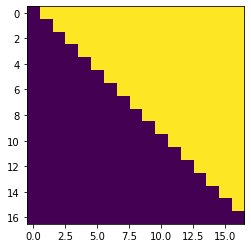

In [118]:
plt.imshow(torch.triu(h.new_ones((17, 17)), diagonal=1).bool().detach().numpy())

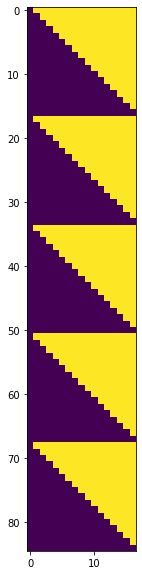

In [140]:
plt.figure(figsize=(5, 10))
t = torch.triu(h.new_ones((17, 17)), diagonal=1).bool()
plt.imshow(
    t.unsqueeze(0).expand(5, 17, 17).contiguous().view(-1, 17).detach().numpy()
)

In [141]:
key_and_value = z

In [187]:
h = emb_dropout(embedded_y)

In [188]:
# Decoder Block 1

## prev는 search를 위한 것
batch_size, m = h.size()[:-1]
fwd_mask = torch.triu(h.new_ones((m, m)), diagonal=1).bool()
fwd_mask = fwd_mask.unsqueeze(0).expand(batch_size, *fwd_mask.size())

## masked MultiHead-Attention
masked_Q_linear_1 = nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE, bias=False)
masked_K_linear_1 = nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE, bias=False)
masked_V_linear_1 = nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE, bias=False)
masked_linear_1   = nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE, bias=False)

Q = K = V = h
mask = fwd_mask

QWs = masked_Q_linear_1(Q).split(HIDDEN_SIZE // N_SPLITS, dim=-1)
KWs = masked_K_linear_1(K).split(HIDDEN_SIZE // N_SPLITS, dim=-1)
VWs = masked_V_linear_1(V).split(HIDDEN_SIZE // N_SPLITS, dim=-1)

QWs = torch.cat(QWs, dim=0)
KWs = torch.cat(KWs, dim=0)
VWs = torch.cat(VWs, dim=0)

mask = torch.cat([mask for _ in range(N_SPLITS)], dim=0)

# Self-Attention
dk = HIDDEN_SIZE // N_SPLITS
softmax = nn.Softmax(dim=-1)
masked_w = torch.bmm(QWs, KWs.transpose(1, 2))
masked_w.masked_fill_(mask, -float('inf'))
masked_w = softmax(masked_w / (dk ** .5))
masked_c = torch.bmm(masked_w, VWs)

masked_c = masked_c.split(Q.size(0), dim=0)
masked_c = masked_linear_1(torch.cat(masked_c, dim=-1))

## Sub-Layer
## LayerNorm(x + Dropout(MultiHeadAttn(x)))
## where MultiHeadAttn(x) == c
masked_attn_norm_1 = nn.LayerNorm(HIDDEN_SIZE)
masked_attn_dropout_1 = nn.Dropout(DROPOUT_P)

h = masked_attn_norm_1(h + masked_attn_dropout_1(masked_c))

## MultiHead-Attention
Q_linear_1 = nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE, bias=False)
K_linear_1 = nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE, bias=False)
V_linear_1 = nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE, bias=False)
linear_1   = nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE, bias=False)

Q = h
V = K = key_and_value
mask = mask_dec

QWs = Q_linear_1(Q).split(HIDDEN_SIZE // N_SPLITS, dim=-1)
KWs = K_linear_1(K).split(HIDDEN_SIZE // N_SPLITS, dim=-1)
VWs = V_linear_1(V).split(HIDDEN_SIZE // N_SPLITS, dim=-1)

QWs = torch.cat(QWs, dim=0)
KWs = torch.cat(KWs, dim=0)
VWs = torch.cat(VWs, dim=0)

mask = torch.cat([mask for _ in range(N_SPLITS)], dim=0)

# Self-Attention
dk = HIDDEN_SIZE // N_SPLITS
softmax = nn.Softmax(dim=-1)
w = torch.bmm(QWs, KWs.transpose(1, 2))
w.masked_fill_(mask, -float('inf'))
w = softmax(w / (dk ** .5))
c = torch.bmm(w, VWs)

c = c.split(Q.size(0), dim=0)
c = linear_1(torch.cat(c, dim=-1))

## Sub-Layer
## LayerNorm(x + Dropout(MultiHeadAttn(x)))
## where MultiHeadAttn(x) == c
attn_norm_1 = nn.LayerNorm(HIDDEN_SIZE)
attn_dropout_1 = nn.Dropout(DROPOUT_P)

h = attn_norm_1(h + attn_dropout_1(c))

### position-wise feed-forward networks
### Attentnion의 결과를 정리해주는 역할을 수행(한다고함)
fc_1 = nn.Sequential(
    nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE * 4),
    nn.ReLU(),
    nn.Linear(HIDDEN_SIZE * 4, HIDDEN_SIZE),
)
fc_norm_1 = nn.LayerNorm(HIDDEN_SIZE)
fc_dropout_1 = nn.Dropout(DROPOUT_P)

h = fc_norm_1(h + fc_dropout_1(fc_1(h)))

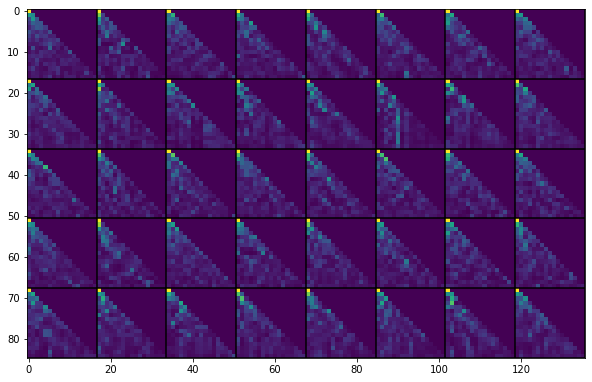

In [189]:
plt.figure(figsize=(10, 8), facecolor='w')
plt.imshow(
    torch.cat(masked_w.split(5), dim=-1).view(5*17, -1).detach().numpy()
)
for i in range(8):
    plt.axvline(17*(i+1)-0.5, color='k')
for i in range(5):
    plt.axhline(17*(i+1)-0.5, color='k')

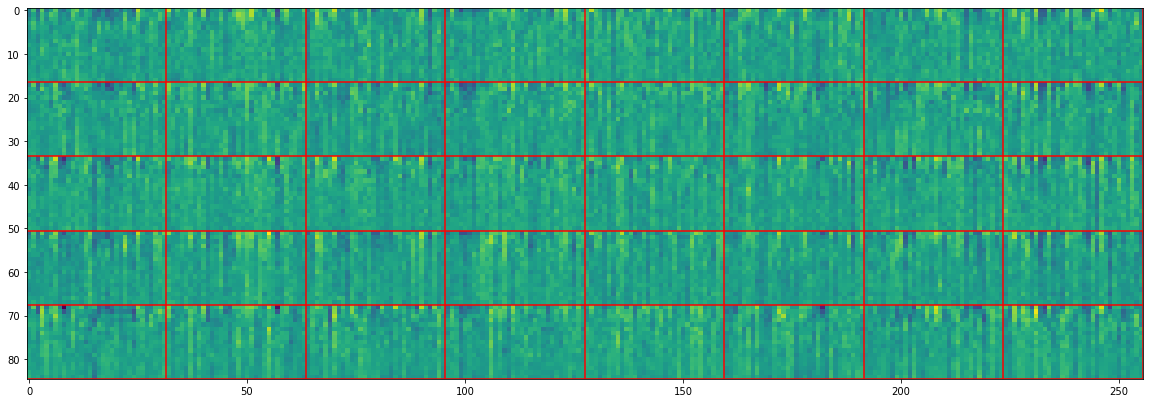

In [190]:
plt.figure(figsize=(20, 16), facecolor='w')
plt.imshow(
    masked_c.view(5*17, -1).detach().numpy()
)
for i in range(8):
    plt.axvline(32*(i+1)-0.5, color='r')
for i in range(5):
    plt.axhline(17*(i+1)-0.5, color='r')

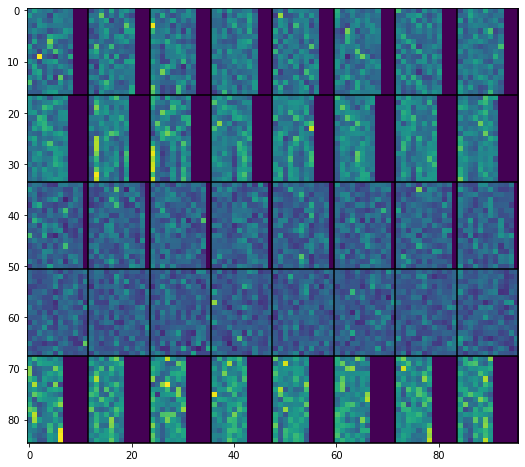

In [191]:
plt.figure(figsize=(10, 8), facecolor='w')
plt.imshow(
    torch.cat(w.split(5), dim=-1).view(5*17, -1).detach().numpy()
)
for i in range(8):
    plt.axvline(12*(i+1)-0.5, color='k')
for i in range(5):
    plt.axhline(17*(i+1)-0.5, color='k')

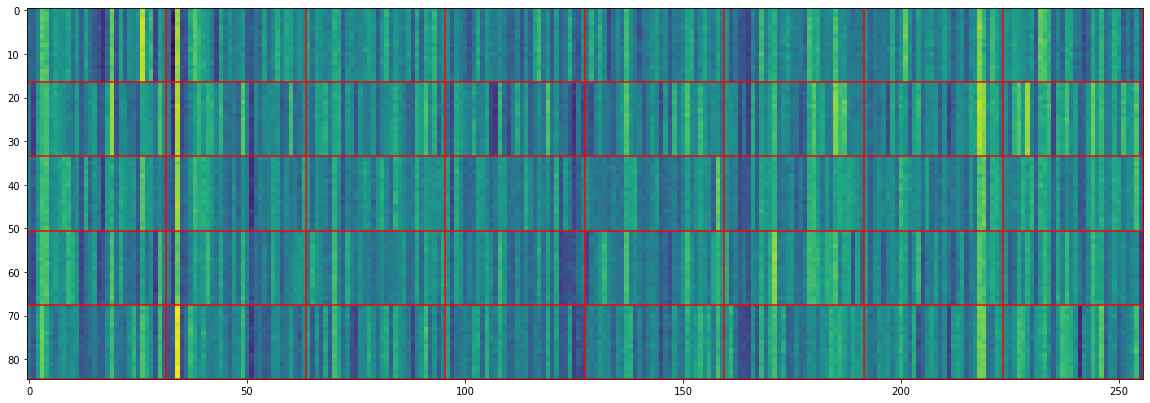

In [193]:
plt.figure(figsize=(20, 16), facecolor='w')
plt.imshow(
    c.view(5*17, -1).detach().numpy()
)
for i in range(8):
    plt.axvline(32*(i+1)-0.5, color='r')
for i in range(5):
    plt.axhline(17*(i+1)-0.5, color='r')

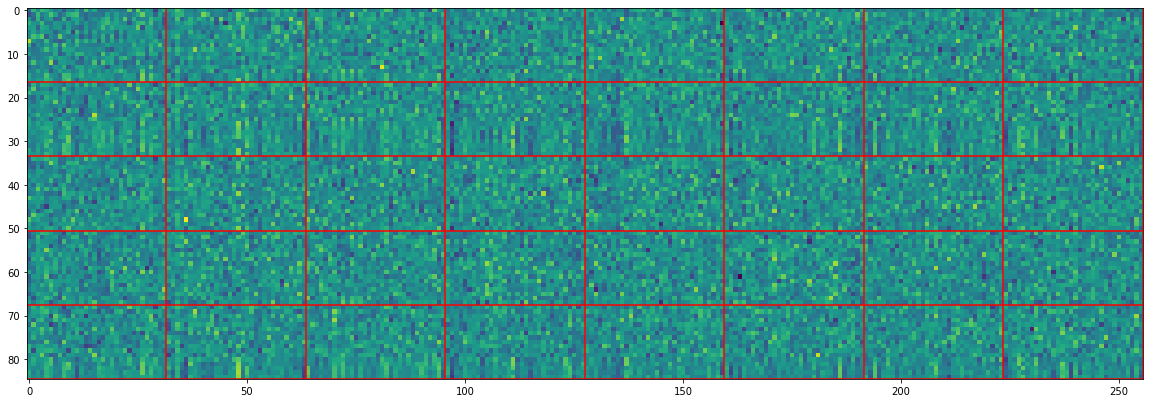

In [195]:
plt.figure(figsize=(20, 16), facecolor='w')
plt.imshow(
    h.view(5*17, -1).detach().numpy()
)
for i in range(8):
    plt.axvline(32*(i+1)-0.5, color='r')
for i in range(5):
    plt.axhline(17*(i+1)-0.5, color='r')

In [196]:
# Decoder Block 2

## prev는 search를 위한 것
batch_size, m = h.size()[:-1]
fwd_mask = torch.triu(h.new_ones((m, m)), diagonal=1).bool()
fwd_mask = fwd_mask.unsqueeze(0).expand(batch_size, *fwd_mask.size())

## masked MultiHead-Attention
masked_Q_linear_2 = nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE, bias=False)
masked_K_linear_2 = nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE, bias=False)
masked_V_linear_2 = nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE, bias=False)
masked_linear_2   = nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE, bias=False)

Q = K = V = h
mask = fwd_mask

QWs = masked_Q_linear_2(Q).split(HIDDEN_SIZE // N_SPLITS, dim=-1)
KWs = masked_K_linear_2(K).split(HIDDEN_SIZE // N_SPLITS, dim=-1)
VWs = masked_V_linear_2(V).split(HIDDEN_SIZE // N_SPLITS, dim=-1)

QWs = torch.cat(QWs, dim=0)
KWs = torch.cat(KWs, dim=0)
VWs = torch.cat(VWs, dim=0)

mask = torch.cat([mask for _ in range(N_SPLITS)], dim=0)

# Self-Attention
dk = HIDDEN_SIZE // N_SPLITS
softmax = nn.Softmax(dim=-1)
masked_w = torch.bmm(QWs, KWs.transpose(1, 2))
masked_w.masked_fill_(mask, -float('inf'))
masked_w = softmax(masked_w / (dk ** .5))
masked_c = torch.bmm(masked_w, VWs)

masked_c = masked_c.split(Q.size(0), dim=0)
masked_c = masked_linear_2(torch.cat(masked_c, dim=-1))

## Sub-Layer
## LayerNorm(x + Dropout(MultiHeadAttn(x)))
## where MultiHeadAttn(x) == c
masked_attn_norm_2 = nn.LayerNorm(HIDDEN_SIZE)
masked_attn_dropout_2 = nn.Dropout(DROPOUT_P)

h = masked_attn_norm_2(h + masked_attn_dropout_2(masked_c))

## MultiHead-Attention
Q_linear_2 = nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE, bias=False)
K_linear_2 = nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE, bias=False)
V_linear_2 = nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE, bias=False)
linear_2   = nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE, bias=False)

Q = h
V = K = key_and_value
mask = mask_dec

QWs = Q_linear_2(Q).split(HIDDEN_SIZE // N_SPLITS, dim=-1)
KWs = K_linear_2(K).split(HIDDEN_SIZE // N_SPLITS, dim=-1)
VWs = V_linear_2(V).split(HIDDEN_SIZE // N_SPLITS, dim=-1)

QWs = torch.cat(QWs, dim=0)
KWs = torch.cat(KWs, dim=0)
VWs = torch.cat(VWs, dim=0)

mask = torch.cat([mask for _ in range(N_SPLITS)], dim=0)

# Self-Attention
dk = HIDDEN_SIZE // N_SPLITS
softmax = nn.Softmax(dim=-1)
w = torch.bmm(QWs, KWs.transpose(1, 2))
w.masked_fill_(mask, -float('inf'))
w = softmax(w / (dk ** .5))
c = torch.bmm(w, VWs)

c = c.split(Q.size(0), dim=0)
c = linear_2(torch.cat(c, dim=-1))

## Sub-Layer
## LayerNorm(x + Dropout(MultiHeadAttn(x)))
## where MultiHeadAttn(x) == c
attn_norm_2 = nn.LayerNorm(HIDDEN_SIZE)
attn_dropout_2 = nn.Dropout(DROPOUT_P)

h = attn_norm_2(h + attn_dropout_2(c))

### position-wise feed-forward networks
### Attentnion의 결과를 정리해주는 역할을 수행(한다고함)
fc_2 = nn.Sequential(
    nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE * 4),
    nn.ReLU(),
    nn.Linear(HIDDEN_SIZE * 4, HIDDEN_SIZE),
)
fc_norm_2 = nn.LayerNorm(HIDDEN_SIZE)
fc_dropout_2 = nn.Dropout(DROPOUT_P)

h = fc_norm_2(h + fc_dropout_2(fc_2(h)))

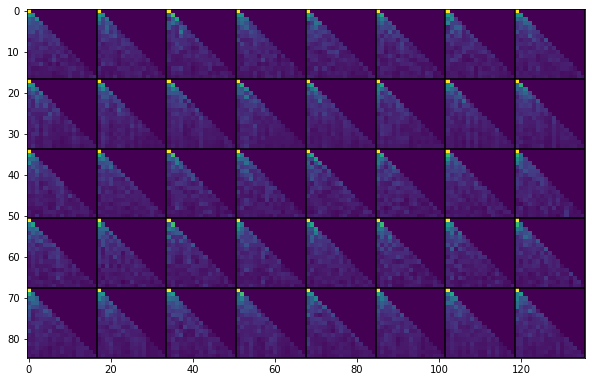

In [197]:
plt.figure(figsize=(10, 8), facecolor='w')
plt.imshow(
    torch.cat(masked_w.split(5), dim=-1).view(5*17, -1).detach().numpy()
)
for i in range(8):
    plt.axvline(17*(i+1)-0.5, color='k')
for i in range(5):
    plt.axhline(17*(i+1)-0.5, color='k')

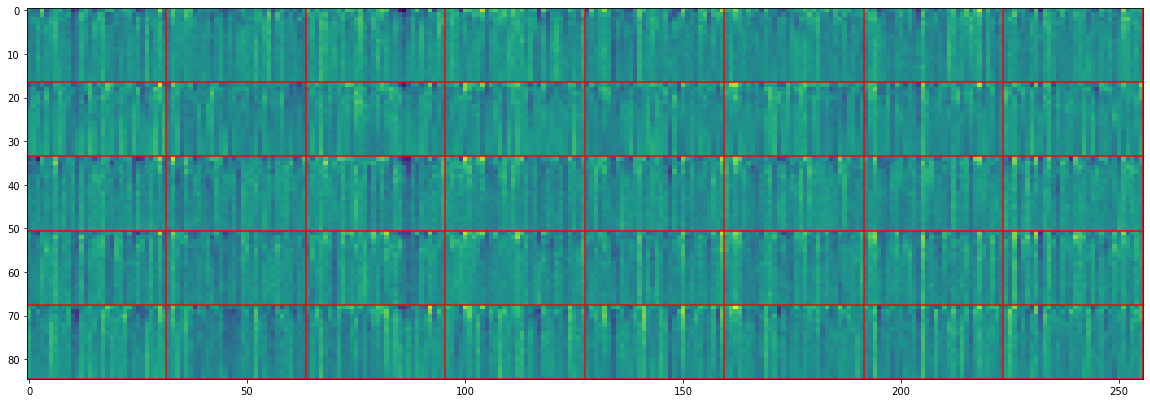

In [198]:
plt.figure(figsize=(20, 16), facecolor='w')
plt.imshow(
    masked_c.view(5*17, -1).detach().numpy()
)
for i in range(8):
    plt.axvline(32*(i+1)-0.5, color='r')
for i in range(5):
    plt.axhline(17*(i+1)-0.5, color='r')

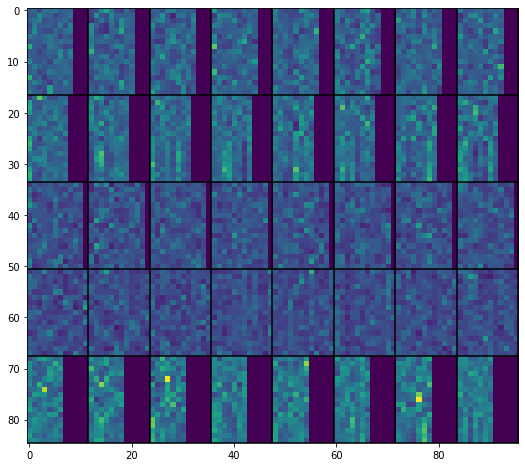

In [199]:
plt.figure(figsize=(10, 8), facecolor='w')
plt.imshow(
    torch.cat(w.split(5), dim=-1).view(5*17, -1).detach().numpy()
)
for i in range(8):
    plt.axvline(12*(i+1)-0.5, color='k')
for i in range(5):
    plt.axhline(17*(i+1)-0.5, color='k')

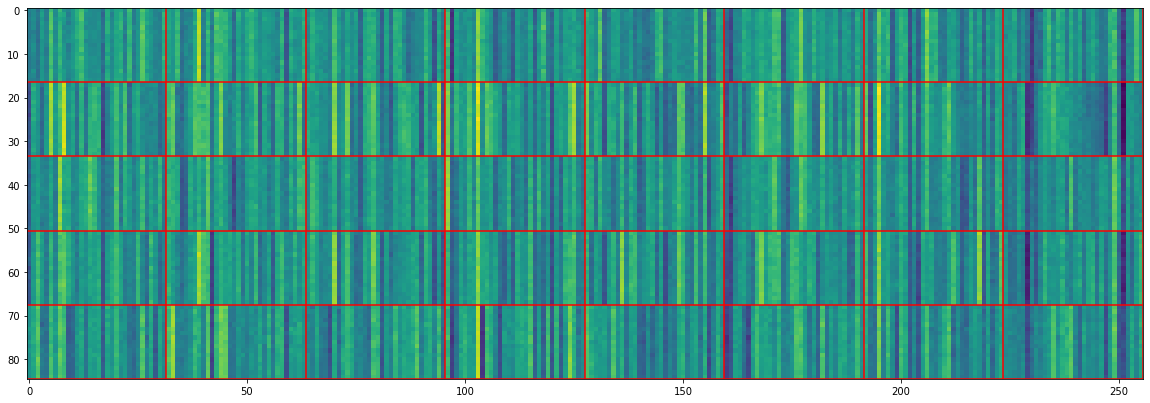

In [200]:
plt.figure(figsize=(20, 16), facecolor='w')
plt.imshow(
    c.view(5*17, -1).detach().numpy()
)
for i in range(8):
    plt.axvline(32*(i+1)-0.5, color='r')
for i in range(5):
    plt.axhline(17*(i+1)-0.5, color='r')

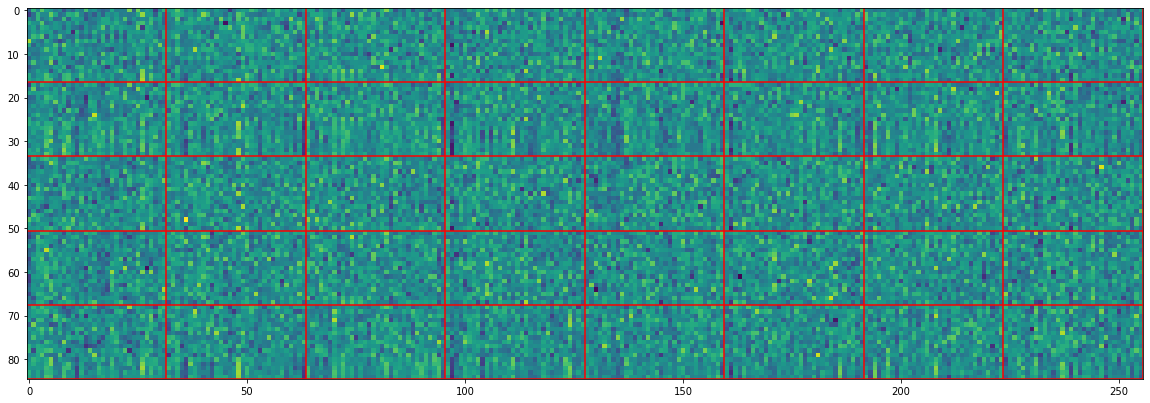

In [201]:
plt.figure(figsize=(20, 16), facecolor='w')
plt.imshow(
    h.view(5*17, -1).detach().numpy()
)
for i in range(8):
    plt.axvline(32*(i+1)-0.5, color='r')
for i in range(5):
    plt.axhline(17*(i+1)-0.5, color='r')

In [202]:
# Decoder Block 3

## prev는 search를 위한 것
batch_size, m = h.size()[:-1]
fwd_mask = torch.triu(h.new_ones((m, m)), diagonal=1).bool()
fwd_mask = fwd_mask.unsqueeze(0).expand(batch_size, *fwd_mask.size())

## masked MultiHead-Attention
masked_Q_linear_3 = nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE, bias=False)
masked_K_linear_3 = nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE, bias=False)
masked_V_linear_3 = nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE, bias=False)
masked_linear_3   = nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE, bias=False)

Q = K = V = h
mask = fwd_mask

QWs = masked_Q_linear_3(Q).split(HIDDEN_SIZE // N_SPLITS, dim=-1)
KWs = masked_K_linear_3(K).split(HIDDEN_SIZE // N_SPLITS, dim=-1)
VWs = masked_V_linear_3(V).split(HIDDEN_SIZE // N_SPLITS, dim=-1)

QWs = torch.cat(QWs, dim=0)
KWs = torch.cat(KWs, dim=0)
VWs = torch.cat(VWs, dim=0)

mask = torch.cat([mask for _ in range(N_SPLITS)], dim=0)

# Self-Attention
dk = HIDDEN_SIZE // N_SPLITS
softmax = nn.Softmax(dim=-1)
masked_w = torch.bmm(QWs, KWs.transpose(1, 2))
masked_w.masked_fill_(mask, -float('inf'))
masked_w = softmax(masked_w / (dk ** .5))
masked_c = torch.bmm(masked_w, VWs)

masked_c = masked_c.split(Q.size(0), dim=0)
masked_c = masked_linear_3(torch.cat(masked_c, dim=-1))

## Sub-Layer
## LayerNorm(x + Dropout(MultiHeadAttn(x)))
## where MultiHeadAttn(x) == c
masked_attn_norm_3 = nn.LayerNorm(HIDDEN_SIZE)
masked_attn_dropout_3 = nn.Dropout(DROPOUT_P)

h = masked_attn_norm_3(h + masked_attn_dropout_3(masked_c))

## MultiHead-Attention
Q_linear_3 = nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE, bias=False)
K_linear_3 = nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE, bias=False)
V_linear_3 = nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE, bias=False)
linear_3   = nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE, bias=False)

Q = h
V = K = key_and_value
mask = mask_dec

QWs = Q_linear_3(Q).split(HIDDEN_SIZE // N_SPLITS, dim=-1)
KWs = K_linear_3(K).split(HIDDEN_SIZE // N_SPLITS, dim=-1)
VWs = V_linear_3(V).split(HIDDEN_SIZE // N_SPLITS, dim=-1)

QWs = torch.cat(QWs, dim=0)
KWs = torch.cat(KWs, dim=0)
VWs = torch.cat(VWs, dim=0)

mask = torch.cat([mask for _ in range(N_SPLITS)], dim=0)

# Self-Attention
dk = HIDDEN_SIZE // N_SPLITS
softmax = nn.Softmax(dim=-1)
w = torch.bmm(QWs, KWs.transpose(1, 2))
w.masked_fill_(mask, -float('inf'))
w = softmax(w / (dk ** .5))
c = torch.bmm(w, VWs)

c = c.split(Q.size(0), dim=0)
c = linear_3(torch.cat(c, dim=-1))

## Sub-Layer
## LayerNorm(x + Dropout(MultiHeadAttn(x)))
## where MultiHeadAttn(x) == c
attn_norm_3 = nn.LayerNorm(HIDDEN_SIZE)
attn_dropout_3 = nn.Dropout(DROPOUT_P)

h = attn_norm_3(h + attn_dropout_3(c))

### position-wise feed-forward networks
### Attentnion의 결과를 정리해주는 역할을 수행(한다고함)
fc_3 = nn.Sequential(
    nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE * 4),
    nn.ReLU(),
    nn.Linear(HIDDEN_SIZE * 4, HIDDEN_SIZE),
)
fc_norm_3 = nn.LayerNorm(HIDDEN_SIZE)
fc_dropout_3 = nn.Dropout(DROPOUT_P)

h = fc_norm_3(h + fc_dropout_3(fc_3(h)))

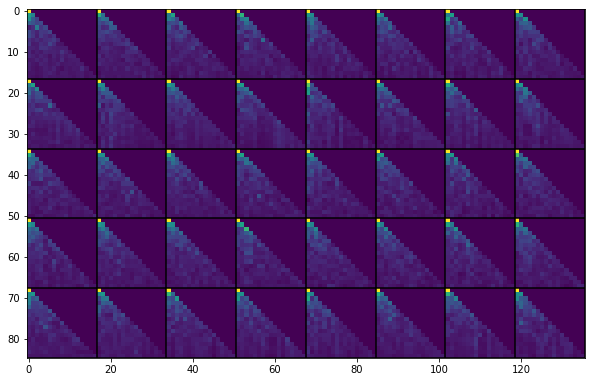

In [204]:
plt.figure(figsize=(10, 8), facecolor='w')
plt.imshow(
    torch.cat(masked_w.split(5), dim=-1).view(5*17, -1).detach().numpy()
)
for i in range(8):
    plt.axvline(17*(i+1)-0.5, color='k')
for i in range(5):
    plt.axhline(17*(i+1)-0.5, color='k')

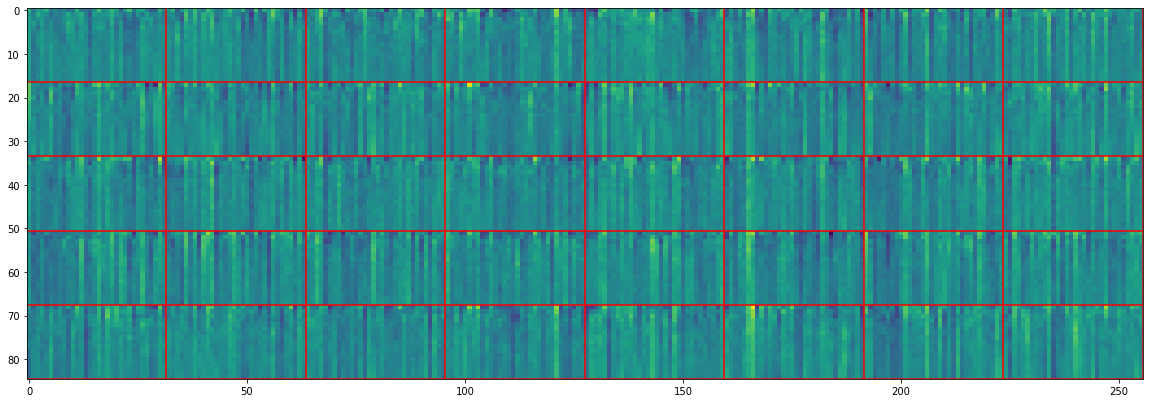

In [206]:
plt.figure(figsize=(20, 16), facecolor='w')
plt.imshow(
    masked_c.view(5*17, -1).detach().numpy()
)
for i in range(8):
    plt.axvline(32*(i+1)-0.5, color='r')
for i in range(5):
    plt.axhline(17*(i+1)-0.5, color='r')

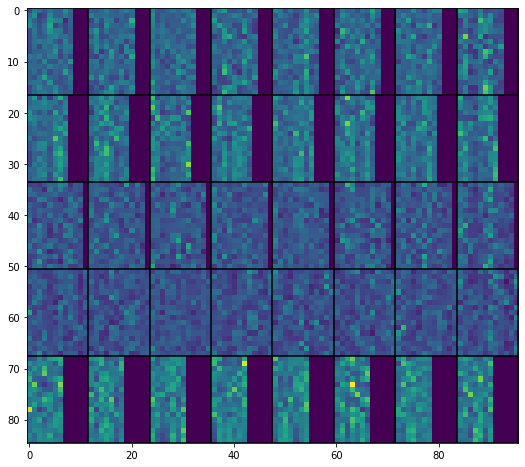

In [207]:
plt.figure(figsize=(10, 8), facecolor='w')
plt.imshow(
    torch.cat(w.split(5), dim=-1).view(5*17, -1).detach().numpy()
)
for i in range(8):
    plt.axvline(12*(i+1)-0.5, color='k')
for i in range(5):
    plt.axhline(17*(i+1)-0.5, color='k')

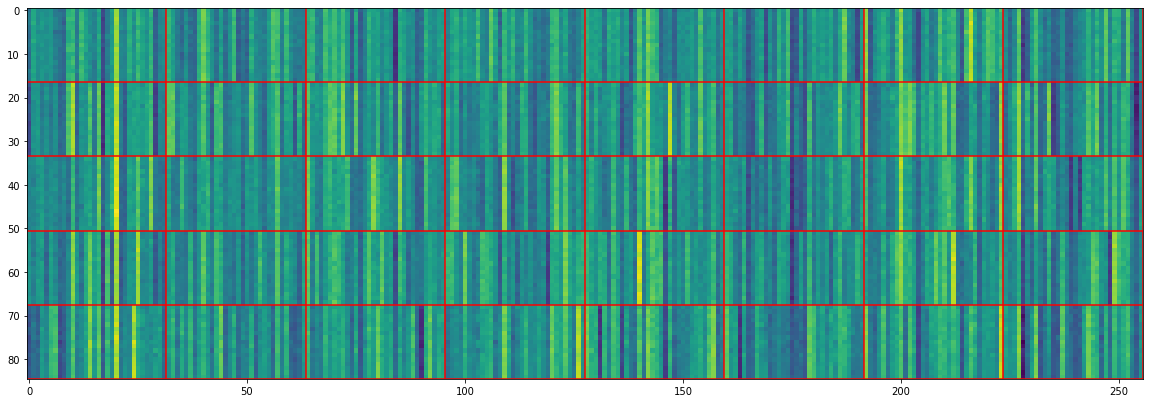

In [208]:
plt.figure(figsize=(20, 16), facecolor='w')
plt.imshow(
    c.view(5*17, -1).detach().numpy()
)
for i in range(8):
    plt.axvline(32*(i+1)-0.5, color='r')
for i in range(5):
    plt.axhline(17*(i+1)-0.5, color='r')

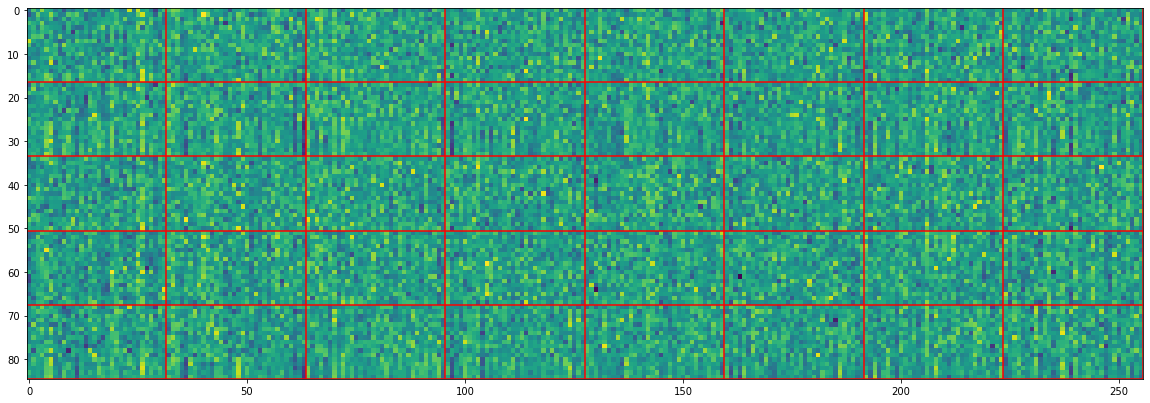

In [209]:
plt.figure(figsize=(20, 16), facecolor='w')
plt.imshow(
    h.view(5*17, -1).detach().numpy()
)
for i in range(8):
    plt.axvline(32*(i+1)-0.5, color='r')
for i in range(5):
    plt.axhline(17*(i+1)-0.5, color='r')

In [210]:
# Decoder Block 4

## prev는 search를 위한 것
batch_size, m = h.size()[:-1]
fwd_mask = torch.triu(h.new_ones((m, m)), diagonal=1).bool()
fwd_mask = fwd_mask.unsqueeze(0).expand(batch_size, *fwd_mask.size())

## masked MultiHead-Attention
masked_Q_linear_4 = nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE, bias=False)
masked_K_linear_4 = nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE, bias=False)
masked_V_linear_4 = nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE, bias=False)
masked_linear_4   = nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE, bias=False)

Q = K = V = h
mask = fwd_mask

QWs = masked_Q_linear_4(Q).split(HIDDEN_SIZE // N_SPLITS, dim=-1)
KWs = masked_K_linear_4(K).split(HIDDEN_SIZE // N_SPLITS, dim=-1)
VWs = masked_V_linear_4(V).split(HIDDEN_SIZE // N_SPLITS, dim=-1)

QWs = torch.cat(QWs, dim=0)
KWs = torch.cat(KWs, dim=0)
VWs = torch.cat(VWs, dim=0)

mask = torch.cat([mask for _ in range(N_SPLITS)], dim=0)

# Self-Attention
dk = HIDDEN_SIZE // N_SPLITS
softmax = nn.Softmax(dim=-1)
masked_w = torch.bmm(QWs, KWs.transpose(1, 2))
masked_w.masked_fill_(mask, -float('inf'))
masked_w = softmax(masked_w / (dk ** .5))
masked_c = torch.bmm(masked_w, VWs)

masked_c = masked_c.split(Q.size(0), dim=0)
masked_c = masked_linear_4(torch.cat(masked_c, dim=-1))

## Sub-Layer
## LayerNorm(x + Dropout(MultiHeadAttn(x)))
## where MultiHeadAttn(x) == c
masked_attn_norm_4 = nn.LayerNorm(HIDDEN_SIZE)
masked_attn_dropout_4 = nn.Dropout(DROPOUT_P)

h = masked_attn_norm_4(h + masked_attn_dropout_4(masked_c))

## MultiHead-Attention
Q_linear_4 = nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE, bias=False)
K_linear_4 = nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE, bias=False)
V_linear_4 = nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE, bias=False)
linear_4   = nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE, bias=False)

Q = h
V = K = key_and_value
mask = mask_dec

QWs = Q_linear_4(Q).split(HIDDEN_SIZE // N_SPLITS, dim=-1)
KWs = K_linear_4(K).split(HIDDEN_SIZE // N_SPLITS, dim=-1)
VWs = V_linear_4(V).split(HIDDEN_SIZE // N_SPLITS, dim=-1)

QWs = torch.cat(QWs, dim=0)
KWs = torch.cat(KWs, dim=0)
VWs = torch.cat(VWs, dim=0)

mask = torch.cat([mask for _ in range(N_SPLITS)], dim=0)

# Self-Attention
dk = HIDDEN_SIZE // N_SPLITS
softmax = nn.Softmax(dim=-1)
w = torch.bmm(QWs, KWs.transpose(1, 2))
w.masked_fill_(mask, -float('inf'))
w = softmax(w / (dk ** .5))
c = torch.bmm(w, VWs)

c = c.split(Q.size(0), dim=0)
c = linear_4(torch.cat(c, dim=-1))

## Sub-Layer
## LayerNorm(x + Dropout(MultiHeadAttn(x)))
## where MultiHeadAttn(x) == c
attn_norm_4 = nn.LayerNorm(HIDDEN_SIZE)
attn_dropout_4 = nn.Dropout(DROPOUT_P)

h = attn_norm_4(h + attn_dropout_4(c))

### position-wise feed-forward networks
### Attentnion의 결과를 정리해주는 역할을 수행(한다고함)
fc_4 = nn.Sequential(
    nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE * 4),
    nn.ReLU(),
    nn.Linear(HIDDEN_SIZE * 4, HIDDEN_SIZE),
)
fc_norm_4 = nn.LayerNorm(HIDDEN_SIZE)
fc_dropout_4 = nn.Dropout(DROPOUT_P)

h = fc_norm_4(h + fc_dropout_4(fc_4(h)))

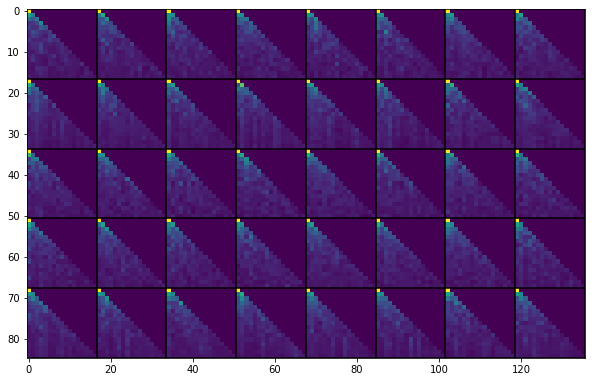

In [211]:
plt.figure(figsize=(10, 8), facecolor='w')
plt.imshow(
    torch.cat(masked_w.split(5), dim=-1).view(5*17, -1).detach().numpy()
)
for i in range(8):
    plt.axvline(17*(i+1)-0.5, color='k')
for i in range(5):
    plt.axhline(17*(i+1)-0.5, color='k')

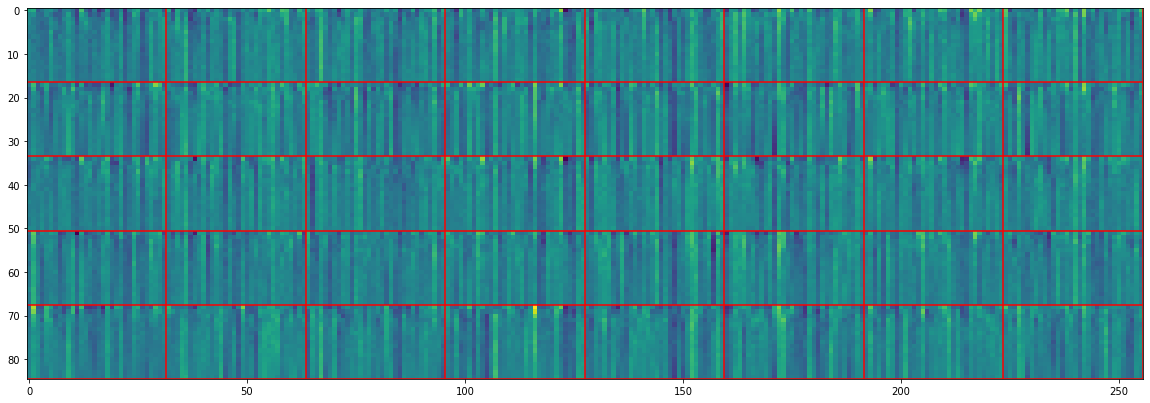

In [212]:
plt.figure(figsize=(20, 16), facecolor='w')
plt.imshow(
    masked_c.view(5*17, -1).detach().numpy()
)
for i in range(8):
    plt.axvline(32*(i+1)-0.5, color='r')
for i in range(5):
    plt.axhline(17*(i+1)-0.5, color='r')

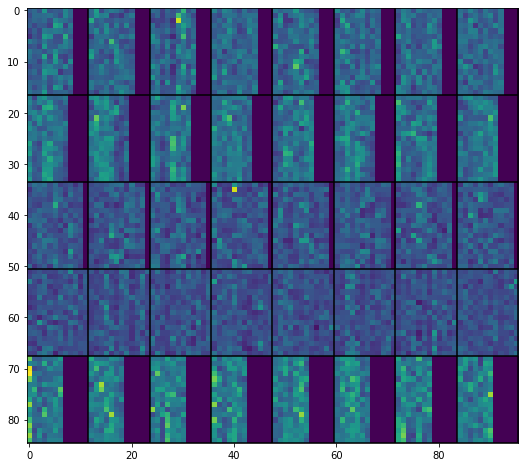

In [213]:
plt.figure(figsize=(10, 8), facecolor='w')
plt.imshow(
    torch.cat(w.split(5), dim=-1).view(5*17, -1).detach().numpy()
)
for i in range(8):
    plt.axvline(12*(i+1)-0.5, color='k')
for i in range(5):
    plt.axhline(17*(i+1)-0.5, color='k')

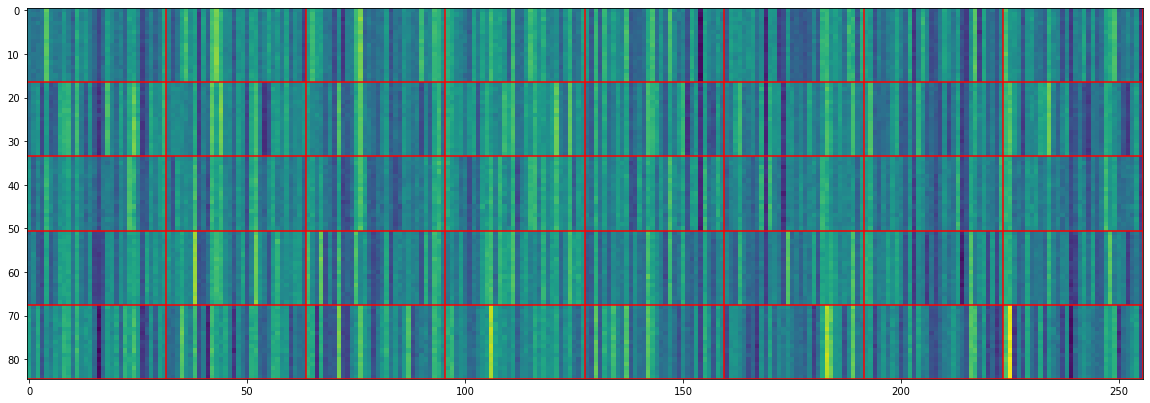

In [214]:
plt.figure(figsize=(20, 16), facecolor='w')
plt.imshow(
    c.view(5*17, -1).detach().numpy()
)
for i in range(8):
    plt.axvline(32*(i+1)-0.5, color='r')
for i in range(5):
    plt.axhline(17*(i+1)-0.5, color='r')

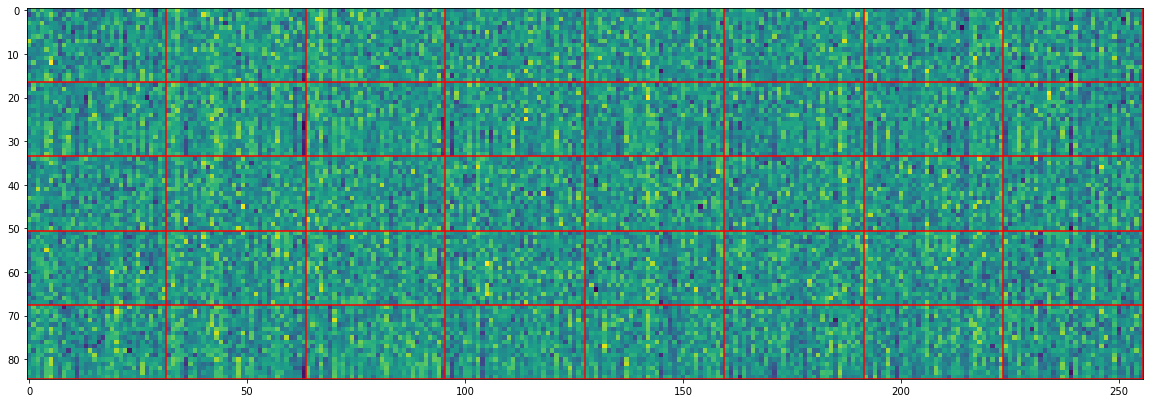

In [215]:
plt.figure(figsize=(20, 16), facecolor='w')
plt.imshow(
    h.view(5*17, -1).detach().numpy()
)
for i in range(8):
    plt.axvline(32*(i+1)-0.5, color='r')
for i in range(5):
    plt.axhline(17*(i+1)-0.5, color='r')

In [216]:
# Decoder Block 5

## prev는 search를 위한 것
batch_size, m = h.size()[:-1]
fwd_mask = torch.triu(h.new_ones((m, m)), diagonal=1).bool()
fwd_mask = fwd_mask.unsqueeze(0).expand(batch_size, *fwd_mask.size())

## masked MultiHead-Attention
masked_Q_linear_5 = nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE, bias=False)
masked_K_linear_5 = nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE, bias=False)
masked_V_linear_5 = nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE, bias=False)
masked_linear_5   = nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE, bias=False)

Q = K = V = h
mask = fwd_mask

QWs = masked_Q_linear_5(Q).split(HIDDEN_SIZE // N_SPLITS, dim=-1)
KWs = masked_K_linear_5(K).split(HIDDEN_SIZE // N_SPLITS, dim=-1)
VWs = masked_V_linear_5(V).split(HIDDEN_SIZE // N_SPLITS, dim=-1)

QWs = torch.cat(QWs, dim=0)
KWs = torch.cat(KWs, dim=0)
VWs = torch.cat(VWs, dim=0)

mask = torch.cat([mask for _ in range(N_SPLITS)], dim=0)

# Self-Attention
dk = HIDDEN_SIZE // N_SPLITS
softmax = nn.Softmax(dim=-1)
masked_w = torch.bmm(QWs, KWs.transpose(1, 2))
masked_w.masked_fill_(mask, -float('inf'))
masked_w = softmax(masked_w / (dk ** .5))
masked_c = torch.bmm(masked_w, VWs)

masked_c = masked_c.split(Q.size(0), dim=0)
masked_c = masked_linear_5(torch.cat(masked_c, dim=-1))

## Sub-Layer
## LayerNorm(x + Dropout(MultiHeadAttn(x)))
## where MultiHeadAttn(x) == c
masked_attn_norm_5 = nn.LayerNorm(HIDDEN_SIZE)
masked_attn_dropout_5 = nn.Dropout(DROPOUT_P)

h = masked_attn_norm_5(h + masked_attn_dropout_5(masked_c))

## MultiHead-Attention
Q_linear_5 = nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE, bias=False)
K_linear_5 = nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE, bias=False)
V_linear_5 = nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE, bias=False)
linear_5   = nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE, bias=False)

Q = h
V = K = key_and_value
mask = mask_dec

QWs = Q_linear_5(Q).split(HIDDEN_SIZE // N_SPLITS, dim=-1)
KWs = K_linear_5(K).split(HIDDEN_SIZE // N_SPLITS, dim=-1)
VWs = V_linear_5(V).split(HIDDEN_SIZE // N_SPLITS, dim=-1)

QWs = torch.cat(QWs, dim=0)
KWs = torch.cat(KWs, dim=0)
VWs = torch.cat(VWs, dim=0)

mask = torch.cat([mask for _ in range(N_SPLITS)], dim=0)

# Self-Attention
dk = HIDDEN_SIZE // N_SPLITS
softmax = nn.Softmax(dim=-1)
w = torch.bmm(QWs, KWs.transpose(1, 2))
w.masked_fill_(mask, -float('inf'))
w = softmax(w / (dk ** .5))
c = torch.bmm(w, VWs)

c = c.split(Q.size(0), dim=0)
c = linear_5(torch.cat(c, dim=-1))

## Sub-Layer
## LayerNorm(x + Dropout(MultiHeadAttn(x)))
## where MultiHeadAttn(x) == c
attn_norm_5 = nn.LayerNorm(HIDDEN_SIZE)
attn_dropout_5= nn.Dropout(DROPOUT_P)

h = attn_norm_5(h + attn_dropout_5(c))

### position-wise feed-forward networks
### Attentnion의 결과를 정리해주는 역할을 수행(한다고함)
fc_5 = nn.Sequential(
    nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE * 4),
    nn.ReLU(),
    nn.Linear(HIDDEN_SIZE * 4, HIDDEN_SIZE),
)
fc_norm_5 = nn.LayerNorm(HIDDEN_SIZE)
fc_dropout_5 = nn.Dropout(DROPOUT_P)

h = fc_norm_5(h + fc_dropout_5(fc_5(h)))

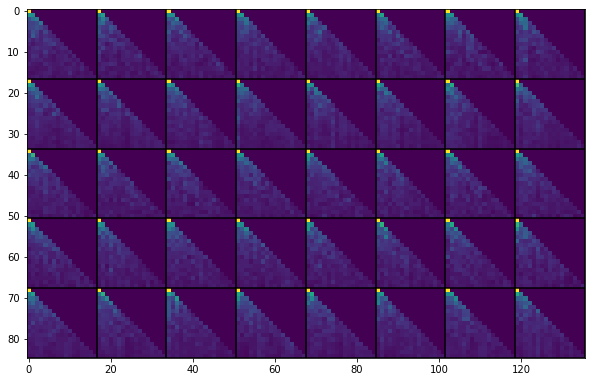

In [217]:
plt.figure(figsize=(10, 8), facecolor='w')
plt.imshow(
    torch.cat(masked_w.split(5), dim=-1).view(5*17, -1).detach().numpy()
)
for i in range(8):
    plt.axvline(17*(i+1)-0.5, color='k')
for i in range(5):
    plt.axhline(17*(i+1)-0.5, color='k')

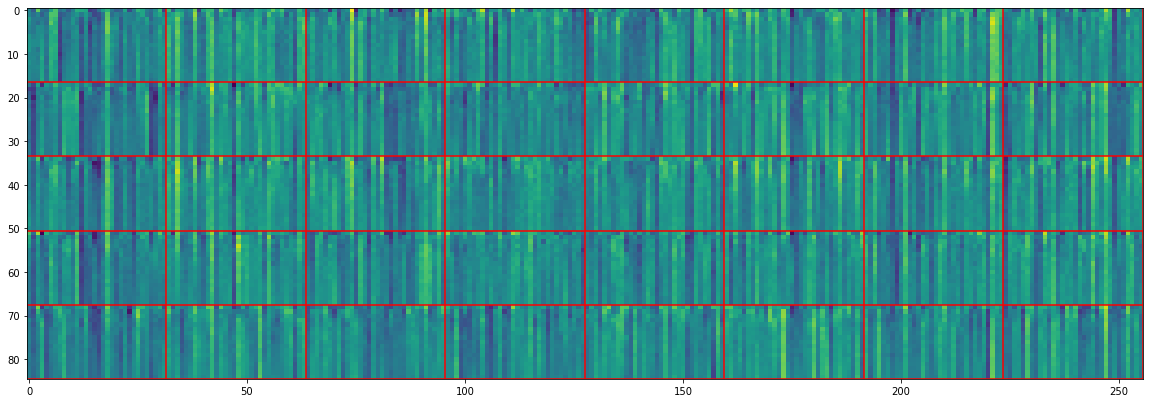

In [218]:
plt.figure(figsize=(20, 16), facecolor='w')
plt.imshow(
    masked_c.view(5*17, -1).detach().numpy()
)
for i in range(8):
    plt.axvline(32*(i+1)-0.5, color='r')
for i in range(5):
    plt.axhline(17*(i+1)-0.5, color='r')

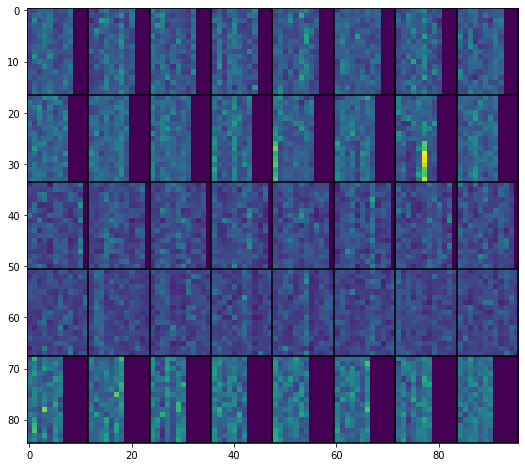

In [219]:
plt.figure(figsize=(10, 8), facecolor='w')
plt.imshow(
    torch.cat(w.split(5), dim=-1).view(5*17, -1).detach().numpy()
)
for i in range(8):
    plt.axvline(12*(i+1)-0.5, color='k')
for i in range(5):
    plt.axhline(17*(i+1)-0.5, color='k')

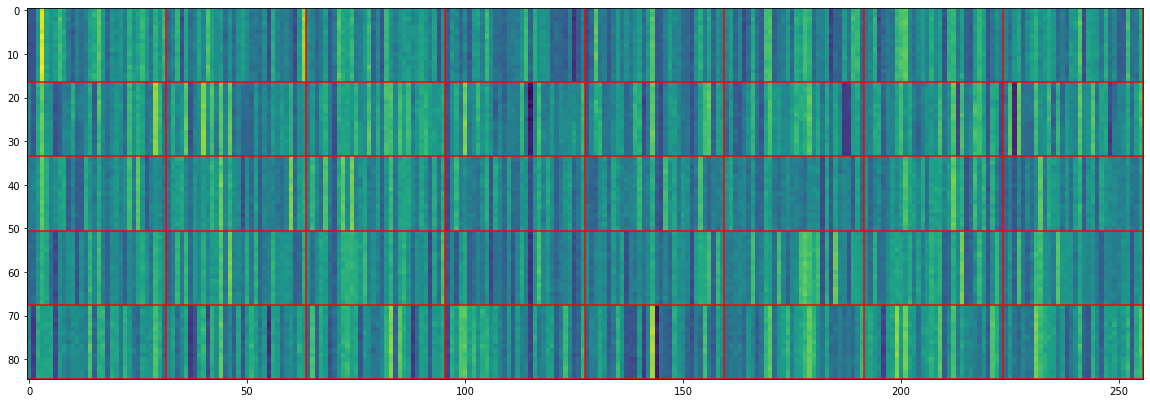

In [220]:
plt.figure(figsize=(20, 16), facecolor='w')
plt.imshow(
    c.view(5*17, -1).detach().numpy()
)
for i in range(8):
    plt.axvline(32*(i+1)-0.5, color='r')
for i in range(5):
    plt.axhline(17*(i+1)-0.5, color='r')

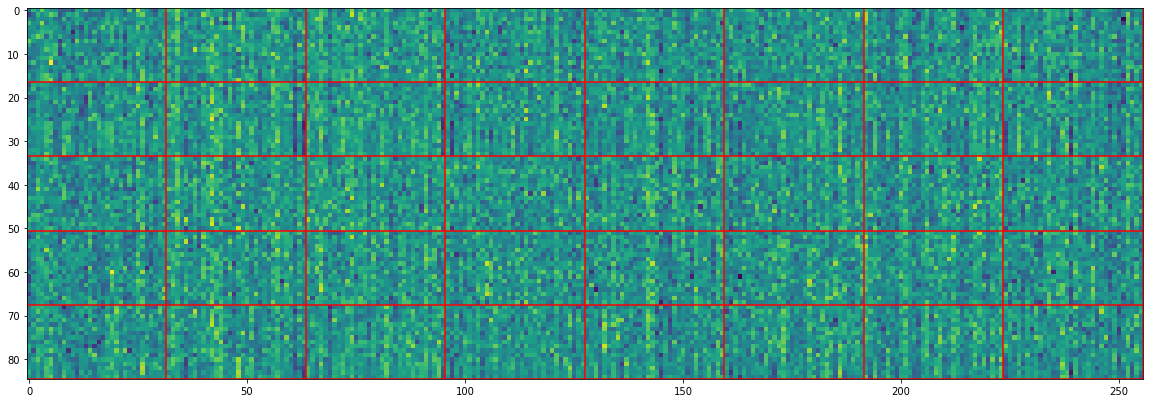

In [221]:
plt.figure(figsize=(20, 16), facecolor='w')
plt.imshow(
    h.view(5*17, -1).detach().numpy()
)
for i in range(8):
    plt.axvline(32*(i+1)-0.5, color='r')
for i in range(5):
    plt.axhline(17*(i+1)-0.5, color='r')

In [222]:
# Decoder Block 6

## prev는 search를 위한 것
batch_size, m = h.size()[:-1]
fwd_mask = torch.triu(h.new_ones((m, m)), diagonal=1).bool()
fwd_mask = fwd_mask.unsqueeze(0).expand(batch_size, *fwd_mask.size())

## masked MultiHead-Attention
masked_Q_linear_6 = nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE, bias=False)
masked_K_linear_6 = nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE, bias=False)
masked_V_linear_6 = nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE, bias=False)
masked_linear_6   = nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE, bias=False)

Q = K = V = h
mask = fwd_mask

QWs = masked_Q_linear_6(Q).split(HIDDEN_SIZE // N_SPLITS, dim=-1)
KWs = masked_K_linear_6(K).split(HIDDEN_SIZE // N_SPLITS, dim=-1)
VWs = masked_V_linear_6(V).split(HIDDEN_SIZE // N_SPLITS, dim=-1)

QWs = torch.cat(QWs, dim=0)
KWs = torch.cat(KWs, dim=0)
VWs = torch.cat(VWs, dim=0)

mask = torch.cat([mask for _ in range(N_SPLITS)], dim=0)

# Self-Attention
dk = HIDDEN_SIZE // N_SPLITS
softmax = nn.Softmax(dim=-1)
masked_w = torch.bmm(QWs, KWs.transpose(1, 2))
masked_w.masked_fill_(mask, -float('inf'))
masked_w = softmax(masked_w / (dk ** .5))
masked_c = torch.bmm(masked_w, VWs)

masked_c = masked_c.split(Q.size(0), dim=0)
masked_c = masked_linear_6(torch.cat(masked_c, dim=-1))

## Sub-Layer
## LayerNorm(x + Dropout(MultiHeadAttn(x)))
## where MultiHeadAttn(x) == c
masked_attn_norm_6 = nn.LayerNorm(HIDDEN_SIZE)
masked_attn_dropout_6 = nn.Dropout(DROPOUT_P)

h = masked_attn_norm_6(h + masked_attn_dropout_6(masked_c))

## MultiHead-Attention
Q_linear_6 = nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE, bias=False)
K_linear_6 = nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE, bias=False)
V_linear_6 = nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE, bias=False)
linear_6   = nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE, bias=False)

Q = h
V = K = key_and_value
mask = mask_dec

QWs = Q_linear_6(Q).split(HIDDEN_SIZE // N_SPLITS, dim=-1)
KWs = K_linear_6(K).split(HIDDEN_SIZE // N_SPLITS, dim=-1)
VWs = V_linear_6(V).split(HIDDEN_SIZE // N_SPLITS, dim=-1)

QWs = torch.cat(QWs, dim=0)
KWs = torch.cat(KWs, dim=0)
VWs = torch.cat(VWs, dim=0)

mask = torch.cat([mask for _ in range(N_SPLITS)], dim=0)

# Self-Attention
dk = HIDDEN_SIZE // N_SPLITS
softmax = nn.Softmax(dim=-1)
w = torch.bmm(QWs, KWs.transpose(1, 2))
w.masked_fill_(mask, -float('inf'))
w = softmax(w / (dk ** .5))
c = torch.bmm(w, VWs)

c = c.split(Q.size(0), dim=0)
c = linear_6(torch.cat(c, dim=-1))

## Sub-Layer
## LayerNorm(x + Dropout(MultiHeadAttn(x)))
## where MultiHeadAttn(x) == c
attn_norm_6 = nn.LayerNorm(HIDDEN_SIZE)
attn_dropout_6= nn.Dropout(DROPOUT_P)

h = attn_norm_6(h + attn_dropout_6(c))

### position-wise feed-forward networks
### Attentnion의 결과를 정리해주는 역할을 수행(한다고함)
fc_6 = nn.Sequential(
    nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE * 4),
    nn.ReLU(),
    nn.Linear(HIDDEN_SIZE * 4, HIDDEN_SIZE),
)
fc_norm_6 = nn.LayerNorm(HIDDEN_SIZE)
fc_dropout_6 = nn.Dropout(DROPOUT_P)

h = fc_norm_6(h + fc_dropout_6(fc_6(h)))

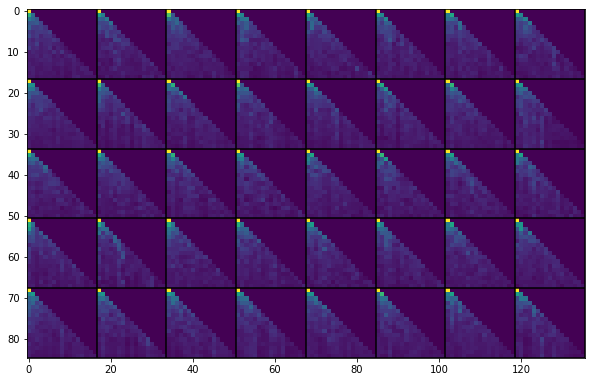

In [223]:
plt.figure(figsize=(10, 8), facecolor='w')
plt.imshow(
    torch.cat(masked_w.split(5), dim=-1).view(5*17, -1).detach().numpy()
)
for i in range(8):
    plt.axvline(17*(i+1)-0.5, color='k')
for i in range(5):
    plt.axhline(17*(i+1)-0.5, color='k')

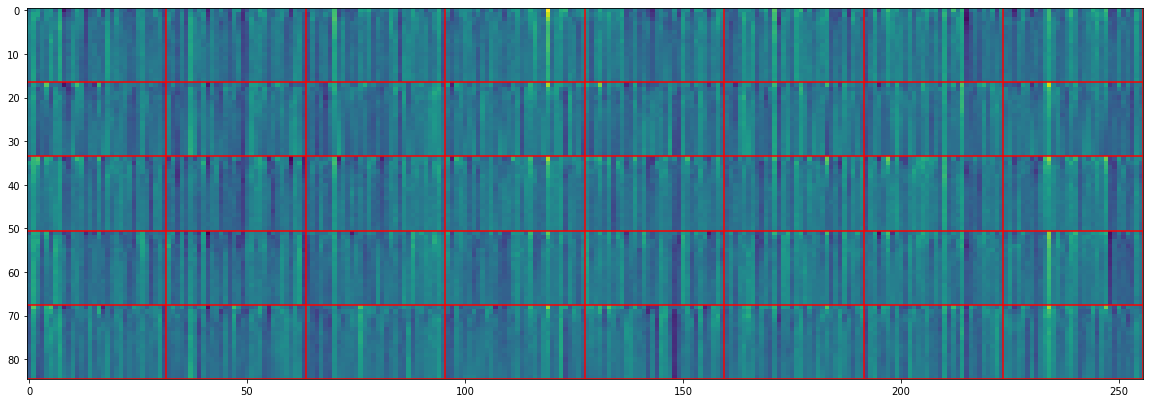

In [224]:
plt.figure(figsize=(20, 16), facecolor='w')
plt.imshow(
    masked_c.view(5*17, -1).detach().numpy()
)
for i in range(8):
    plt.axvline(32*(i+1)-0.5, color='r')
for i in range(5):
    plt.axhline(17*(i+1)-0.5, color='r')

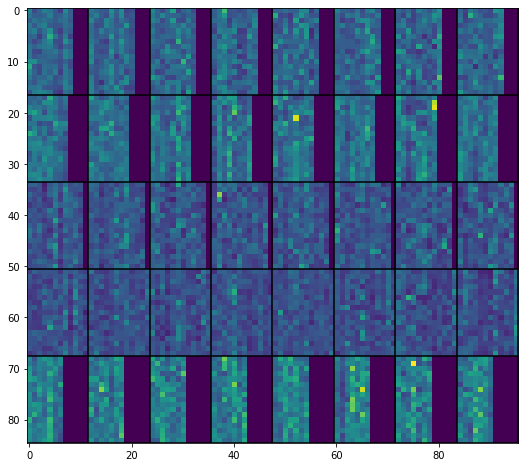

In [225]:
plt.figure(figsize=(10, 8), facecolor='w')
plt.imshow(
    torch.cat(w.split(5), dim=-1).view(5*17, -1).detach().numpy()
)
for i in range(8):
    plt.axvline(12*(i+1)-0.5, color='k')
for i in range(5):
    plt.axhline(17*(i+1)-0.5, color='k')

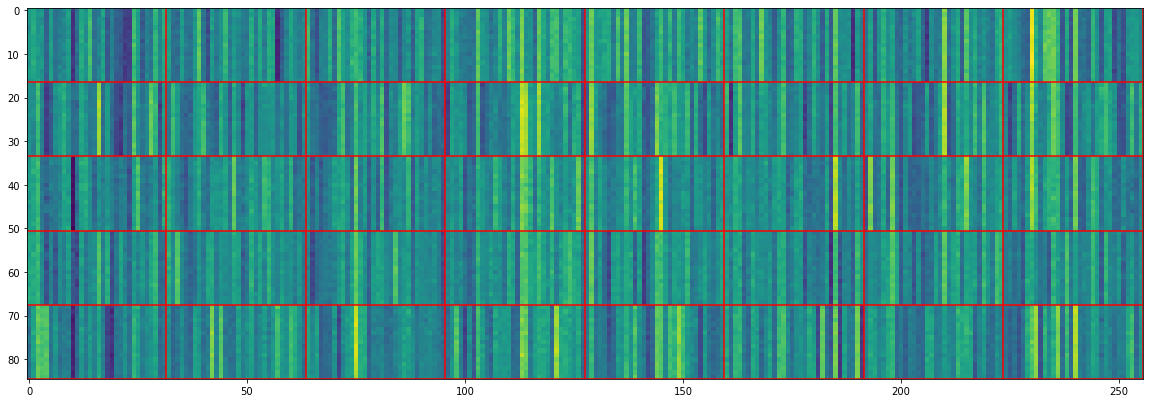

In [226]:
plt.figure(figsize=(20, 16), facecolor='w')
plt.imshow(
    c.view(5*17, -1).detach().numpy()
)
for i in range(8):
    plt.axvline(32*(i+1)-0.5, color='r')
for i in range(5):
    plt.axhline(17*(i+1)-0.5, color='r')

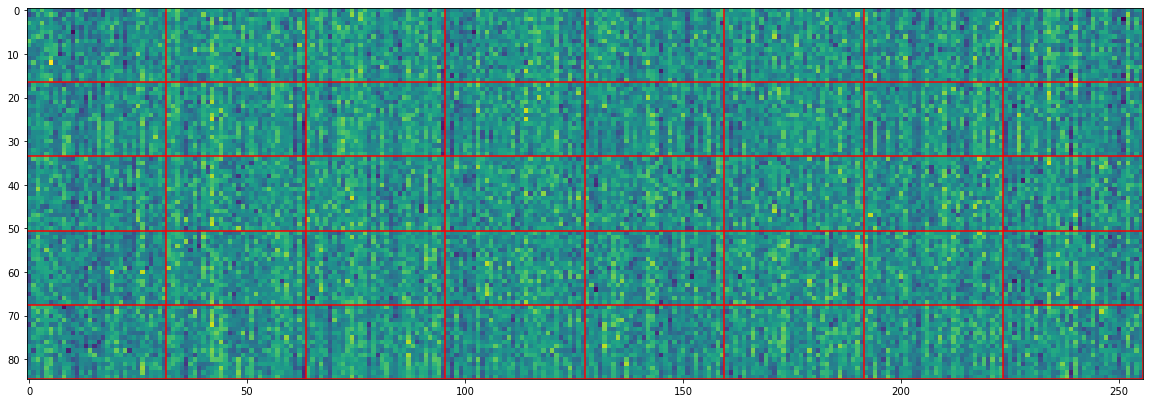

In [227]:
plt.figure(figsize=(20, 16), facecolor='w')
plt.imshow(
    h.view(5*17, -1).detach().numpy()
)
for i in range(8):
    plt.axvline(32*(i+1)-0.5, color='r')
for i in range(5):
    plt.axhline(17*(i+1)-0.5, color='r')

In [230]:
output = nn.Linear(HIDDEN_SIZE, OUTPUT_SIZE)
logsoftmax = nn.LogSoftmax(dim=-1)

In [231]:
y_pred = softmax(output(h))

In [233]:
y_pred.shape

torch.Size([5, 17, 34308])